# Out of sample testing of portfolio allocations

### The Hidden Markov Model

#### 2 states with switching mean and covariance

We look at a 2-state HMM with state switching mean and covariance matrix. Our intent is to compare a 5 year investment horizon out of sample. Concretely, this means fitting a $2HMM_{(1,1)}$ to data, simulating five years of returns, optimising a portfolio based on these returns, and comparing with a portfolio optimised to the actual returns. Later, we will compare with returns based on a simplified linear multivariate Gaussian model, that is, where the moments are non switching.

First, we read times series of prices collected from Bloomberg.

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import optimize as opt
from numba import jit
import time
import pyfolio as pf
import empyrical as ep

In [2]:
prices = pd.read_csv(
            # '/home/william/Dropbox/Thesis/mthReturns.csv',
            'C:/Users/willi/Dropbox/Thesis/mthReturns.csv',
            index_col=0,
            header=0)
prices = prices.drop(['SPXT'], axis=1)
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()
colNames = ['High Yield',
            'Investment Grade',
            'Commodities',
            'Russell 2000',
            'Russell 1000']
prices.columns = colNames
display(prices.head())

,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
1983-07-29,98.21,200.49,53.6360,119.5855,90.9526
1983-08-31,99.41,201.55,58.0218,114.7932,91.4312
1983-09-30,101.94,208.85,56.4019,116.6039,92.6432
1983-10-31,102.91,208.76,53.4022,108.4035,90.4636
1983-11-30,103.62,211.27,54.4145,113.8557,92.2843


### Prices
We consider time series on five asset classes, namely:

* High Yield (HY)
* Investment Grade (IG)
* Commodities (C)
* Russell 2000 (R2)
* Russell 1000 (R1)

In particular, we consider the development in the **prices** of these assets over the period `1983-07-29` to `2018-12-31`.

We note below that prices have been increasing steadily over the period.

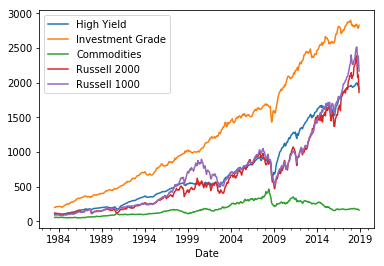

In [3]:
prices.plot()
plt.show()

### Risk Free investment

The risk-free investment is an investment into an asset which is deemed practically impossible to lose money on. The typical bet is a 10 year US government bond or the German 10 year bund.

For the risk free asset, we have to remember to divide by `100`, as the time series reflects interest (in percent, not decimal points) of investment in the risk free asset.

In [4]:
rf_data = pd.read_csv(
            # '/home/william/Dropbox/Thesis/rf.csv',
            'C:/Users/willi/Dropbox/Thesis/rf.csv',
            index_col=0,
            header=0
        )
rf_data = rf_data / 100.0
rf_data.index = pd.to_datetime(rf_data.index)
rf_data = rf_data.sort_index()
rf_data.head()

,RF
Date,
1983-07-29,0.0074
1983-08-31,0.0076
1983-09-30,0.0076
1983-10-31,0.0076
1983-11-30,0.0070


##### Quantitative easing

We note in the risk free asset that the interest fell to approximately zero over the period of 2009 to 2016. This is of course a reflection of quantitative easing, the stimulus package provided by the US Federal Reserve to incentivise investments from a funding cost perspective.

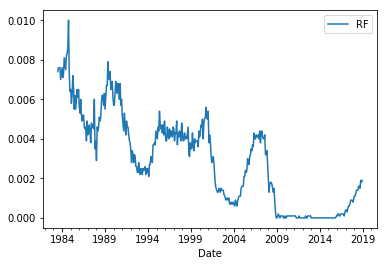

In [5]:
rf_data.plot()

### Returns on our assets

We compute returns by the logarithmic method, i.e.

$$ r_t = \log\left(\frac{p_t}{p_{t-1}}\right), $$

where $p_t$ is the price at time $t$.

We note that the first period will not have a lagged price, and thus the computation returns an `NAN`. This has to be removed.

In [6]:
returns = np.log(prices/prices.shift(1))
returns = returns.dropna()
display(returns.head())
display(returns.tail())

,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
1983-08-31,0.012145,0.005273,0.078598,-0.040899,0.005248
1983-09-30,0.025132,0.035579,-0.028316,0.015650,0.013169
1983-10-31,0.009470,-0.000431,-0.054651,-0.072922,-0.023808
1983-11-30,0.006876,0.011952,0.018779,0.049071,0.019926
1983-12-30,-0.006778,-0.003129,0.013858,-0.021108,-0.012308


,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
2018-08-31,0.007347,0.004927,-0.017864,0.042170,0.033877
2018-09-28,0.005555,-0.003572,0.018995,-0.024348,0.003790
2018-10-31,-0.016114,-0.014712,-0.021824,-0.114980,-0.073392
2018-11-30,-0.008640,-0.001666,-0.005647,0.015676,0.020140
2018-12-31,-0.021646,0.014599,-0.071363,-0.126520,-0.095539


##### Left skew in returns

In alignment with financial theory, we note a left-skew in the returns, that is, we note more returns that are severely negative as opposed to strongly positive.

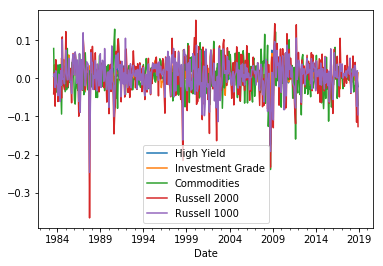

In [7]:
returns.plot()

### Excess returns

In order to compute excess returns we must subtract the risk free rate from each of our 5 assets.

We need the risk free return data to be a regular array in order to subtract this from returns on our assets, as the data frame does not provide an obvious approach to this subtraction.

In addition, we must remove the first observation, as we have no returns computed for August 29th in our returns data set.

In [8]:
rf = np.array(rf_data.iloc[1:,0])

# Show the original data for comparison
display(rf_data.head(6))

# Show the new series - is it shifted one period? Yes.
display(pd.DataFrame(rf[:5], columns=['RF']).head())

,RF
Date,
1983-07-29,0.0074
1983-08-31,0.0076
1983-09-30,0.0076
1983-10-31,0.0076
1983-11-30,0.0070
1983-12-30,0.0073


,RF
0,0.0076
1,0.0076
2,0.0076
3,0.0070
4,0.0073


##### Excess returns computation

Subtracting the risk-free rate from the return process generates `excess returns`.

In [9]:
excess_returns = returns.sub(rf, axis = 0)
display(excess_returns.head())
display(excess_returns.tail())

,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
1983-08-31,0.004545,-0.002327,0.070998,-0.048499,-0.002352
1983-09-30,0.017532,0.027979,-0.035916,0.008050,0.005569
1983-10-31,0.001870,-0.008031,-0.062251,-0.080522,-0.031408
1983-11-30,-0.000124,0.004952,0.011779,0.042071,0.012926
1983-12-30,-0.014078,-0.010429,0.006558,-0.028408,-0.019608


,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
2018-08-31,0.005747,0.003327,-0.019464,0.040570,0.032277
2018-09-28,0.004055,-0.005072,0.017495,-0.025848,0.002290
2018-10-31,-0.018014,-0.016612,-0.023724,-0.116880,-0.075292
2018-11-30,-0.010440,-0.003466,-0.007447,0.013876,0.018340
2018-12-31,-0.023546,0.012699,-0.073263,-0.128420,-0.097439


##### Heavy left skew in excess returns

Again, plotting the time series we see a heavy negative tail, implying that negative outliers were more negative (and perhaps more frequent also) than positive outliers. This is a stylized fact.

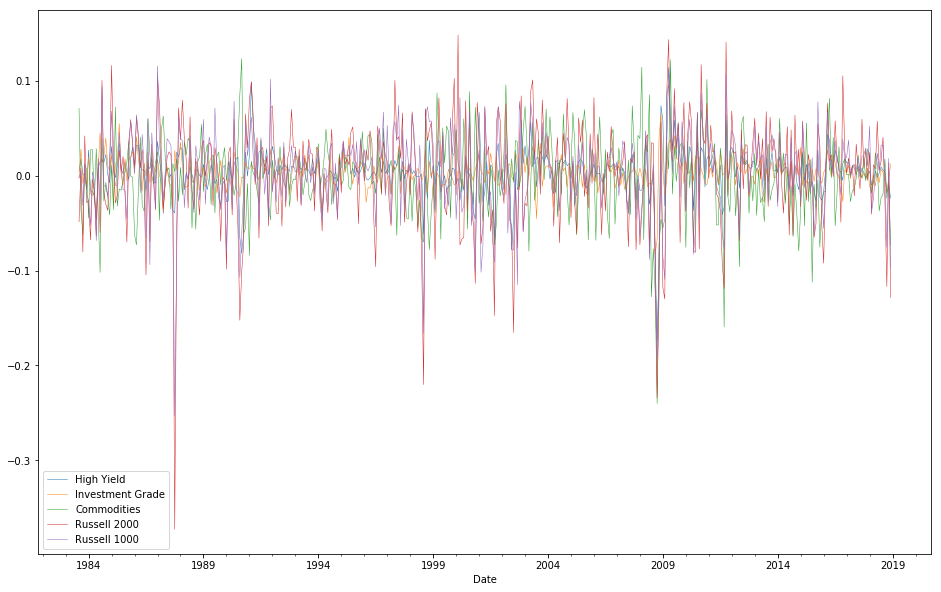

In [10]:
excess_returns.plot(linewidth = 0.5, figsize = (16,10))

The above data are likewise compiled in a script I call "genData.py". What we have generated is:

* monthly prices (prices)
* monthly returns (returns)
* monthly excess returns (excess_returns)
* monthly risk-free rate (rf_data)

The goal is to use this data as ground for comparison with existing data.

We use data up until and including December 2017 to estimate a 2-state multivariate Hidden Markov Model (HMM). This model is written as:

$$
Y_t = \mu_{s_t} + \Sigma_{s_t}^{1/2}, \\
\Sigma_{s_t} \sim \text{iid}N\left(0, \Omega_{s_t}\right), \\
s_t \in \{1, 2\}, \quad \forall t \geq 0.
$$


### Estimated parameters

Estimating parameters up until and including December 2017 in Matlab, we find the following.

In [11]:
cols = {1, 2}
idx = colNames

# 2013 estimates
mu = np.array([
    [0.4630, 0.2958],
    [0.2202, 0.4071],
    [0.3380, 0.1409],
    [0.7841, -0.7157],
    [0.8274, 0.0759]
])

cov = np.array([
    [
        [1.99231, 1.36487, 0.37123, 2.99855, 2.61054],
        [1.36487, 2.16692, -0.06630, 1.05048, 1.60245],
        [0.37123, -0.06630, 12.01824, 2.76506, 1.90716],
        [2.99855, 1.05048, 2.76506, 17.08546, 11.06018],
        [2.61054, 1.60245, 1.90716, 11.06018, 10.21645]
    ],
    [
        [17.54800, 3.34101, 6.55589, 22.19526, 16.02338],
        [3.34101, 4.09198, 1.55628, -0.09049, 1.46926],
        [6.55589, 1.55628, 33.26028, 8.46432, 6.03756],
        [22.19526, -0.09049, 8.46432, 72.22134, 46.50698],
        [16.02338, 1.46926, 6.03756, 46.50698, 42.42729]
        
    ]
])

probs = np.array([
    [0.94, 0.19],
    [0.06, 0.81]
])

print('State 1: pos. semi. def?: ', np.all(np.linalg.eigvals(cov[0])>0))
print('State 1: symmetric?: ', np.allclose(cov[0],cov[0].T))

print('State 2: pos. semi. def?: ', np.all(np.linalg.eigvals(cov[1])>0))
print('State 2 symmetric?: ', np.allclose(cov[1],cov[1].T))


"""
# 2017 estimates
mu = np.array([
    [0.3815, 0.1523],
    [0.1875, 0.3174],
    [0.0048, 0.0190],
    [0.4185, -0.4411],
    [0.6141, -0.1652]
])

cov = np.array([
    [
        [1.97569, 1.38601, 0.37623, 2.90098, 2.50570],
        [1.38601, 2.15937, -0.36313, 1.08337, 1.59527],
        [0.37623, -0.36313, 11.51764, 2.04866, 1.19757],
        [2.90098, 1.08337, 2.04866, 15.98839, 10.02691],
        [2.50570, 1.59527, 1.19757, 10.02691, 9.22943]
    ],
    [
        [15.76381, 3.35970, 5.91590, 21.88487, 15.67456],
        [3.35970, 3.23990, 1.40257, 2.59855, 2.58191],
        [5.91590, 1.40257, 31.17319, 9.71158, 7.74556],
        [21.88487, 2.59855, 9.71158, 69.81108, 47.04726],
        [15.67456, 2.58191, 7.74556, 47.04726, 41.68768]
    ]
])

probs = np.array([
    [0.95, 0.13],
    [0.05, 0.87]
])

"""

mu_df = pd.DataFrame(mu, columns = cols, index = idx)

covs = [pd.DataFrame(
    cov[i],
    index=colNames,
    columns=colNames
    ) for i in range(cov.shape[0])]

mask = np.ones_like(cov[0])
mask[np.triu_indices_from(mask)] = False  # False error call

('State 1: pos. semi. def?: ', True)
('State 1: symmetric?: ', True)
('State 2: pos. semi. def?: ', True)
('State 2 symmetric?: ', True)


#### Means

Means are positive in all states for bonds and commodities, and negative for equities.

*Commodities* have a really low return on average, and effectively zero in state 1.

*Russell 2000* has worse returns on average in the negative state, than they are good in the positive state. Luckily for investors in Russell 2000 the positive state is predominant in our data set, meaning returns accummulate positively.

The rest - have a look at the heat map below

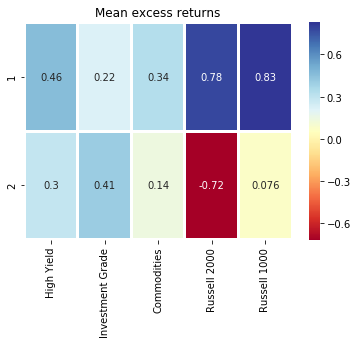

In [12]:
sns.heatmap(
    mu_df.T, annot=True, cmap='RdYlBu', linewidths=2
)
plt.title('Mean excess returns')
plt.show()

#### Covariance matrix

State 2 is associated with higher volatility across the board even covariances are all larger in state 2

*Russell 2000* is particularly affected by high variance, but it is true for equities in general that they are more variable than bonds

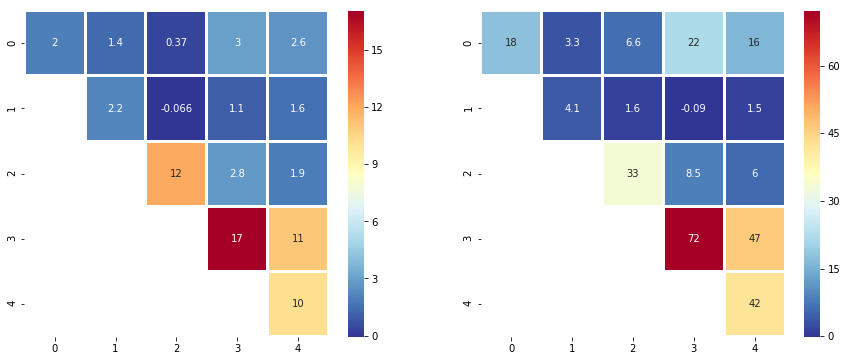

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
for i, ax in enumerate(axes.flat):
    sns.heatmap(
        cov[i], annot=True, cmap='RdYlBu_r', mask=mask, linewidths=2, ax=ax
    )
plt.show()

#### Transition matrix

State 1 is more persistant, with an average duration of $1 / (1 - 0.95) = 20$ months, as opposed to state 2 with an average duration of 7.7 months.

Formally, the matrix is given by:


$$ \mathbf{P} = \begin{pmatrix} p_{11} & 1 - p_{22} \\ 1 - p_{11} & p_{22} \end{pmatrix}. $$

In [14]:
print('From column index to row, i.e. with probability: ', probs[0,1], "we go from state 2 to state 1")
pd.DataFrame(probs,
             index = ['To 1', 'To 2'],
             columns = ['From 1','From 2'])

('From column index to row, i.e. with probability: ', 0.19, 'we go from state 2 to state 1')


,From 1,From 2
To 1,0.94,0.19
To 2,0.06,0.81


## Simulating states

Now that we have a matrix of state-means (excess) and likewise matrices of covariances, we are ready to simulate states processes.

From the probability matrix given above, we have that, starting in state 1, we stay in state 2 with 95\% probability.  To simulate a path which switches with 95\% from state 1 to state 2 we use uniform random numbers, i.e.

$$ p_{11} < u\in[0,1] \leq p_{11} + p_{12}$$

indicates that we are going to state 2, if the statement is true.

Specifically, we draw a random uniform number $u\in[0,1]$. This number, since it is uniform random on the unit interval $[0,1]$, has a 95\% chance of being 0.95 or lower. Thus, if we start the simulation in state 1 and we draw $u^{(1)} \in (0.95,1.00]$ we switch over to state 2. Likewise, if we start in state 2 and draw $u\in (0.87,1.00]$ then we switch to state 1. *2017 estimates*.

This is the function we have defined below.

In [15]:
@jit(nopython=True)
def stateSim(S, M, start, probs, T, u, seed=12345):
    np.random.seed(seed)
    statePaths = np.ones((M, T)) * start
    state = np.ones(S)
    stateFreq = np.ones((M, S))
    for m in range(M):
        for t in range(T-1):
            # i defines state we are arriving from
            i = int(statePaths[m, t] - 1)
            for s in range(S):
                # Identifies which state we transition to
                state[s] = (np.sum(probs[:s, i]) < u[m, t] <= np.sum(probs[:s+1, i]))*(s+1)
            statePaths[m, t+1] = np.sum(state)
        for s in range(S):
            stateFreq[m, s] = np.sum(statePaths[m] == s + 1)
    return statePaths, stateFreq

##### Performing the simulation

The function above is general to allow for any amount of states. We need parameters:

* S: Amount of states (2 in this case)
* M: Amount of simulations (we use 50,000 as a default)
* start: Which state we start in (1 or 2)
* T: Investment horizon in months (e.g. 12 months is 1 year)

We repeat the simulation for starting states 1 and 2 respectively.

In [16]:
S, M, start1, start2, T = 2, 50000, 1, 2, 60
u = np.random.random((M,T))

sp1, sf1 = stateSim(S, M, start1, probs, T, u)
sp2, sf2 = stateSim(S, M, start2, probs, T, u)

##### Reversion

Starting in state 1 means that we must see an increasing probability of ending in state 2 and vice versa. The below plots are the averages over 50,000 simulated state paths, for each month in the investment horizon.

Starting in state 1 and with just 5 pct. probability of exiting state 1 in any given month we still see that we do indeed end in state 2 25 pct. of the time. Likewise, starting in state 2 we find ourselves transition to state 1 with increasing probability, having approximately 65 \% chance of ending in state 1.

$$ (\pi * 1 + (1 - \pi) * 2) = 1.3 \Leftrightarrow \\
1.3 - 2 = -\pi \\
\pi = 0.7$$


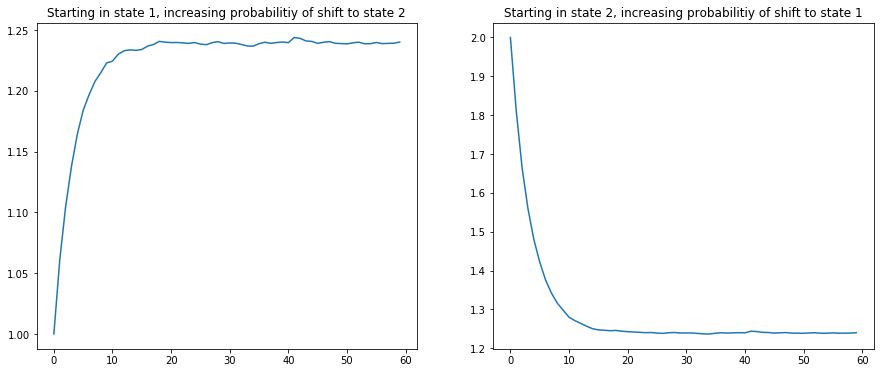

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax1.plot(sp1.mean(axis=0))
ax1.set_title('Starting in state 1, increasing probabilitiy of shift to state 2')
ax2.plot(sp2.mean(axis=0))
ax2.set_title('Starting in state 2, increasing probabilitiy of shift to state 1')
plt.show()

*Be aware from the above - they are both "equally" unstable, as should be. This does not appear that way, because the y-axis on the right panel is much wider than that of the left panel*

## Simulating returns

In addition to states, to filter through means and covariances for each state, and ultimately produce return series. See model specification for returns and volatility dynamics. We continue the assumption of a multivariate standard Gaussian model, conditional on the state.

In [18]:
@jit
def returnSim(S, M, N, A, start, mu, cov, probs, T, u, seed=12345):
    np.random.seed(seed)
    states, freq = stateSim(S, M, start, probs, T, u)
    returns = np.zeros((M*N, A, T))
    for m in range(M):
        for n in range(N):
            for s in range(S):
                returns[m*N + n, :, states[m] == s + 1] = \
                    np.random.multivariate_normal(
                        mu[:, s], cov[s], int(freq[m, s])
                    )
    return returns, states

We need the following variables to execute the simulation:

* S: states = 2
* M: state path simulations = 50,000
* N: return path simulations per state path simulation = 1
* A: amount of assets (excl. risk free rate - we are not simulating that)
* start: state from which we set off = start1 or start2
* mu: parameter estimates for state switching mean
* cov: parameter estimates for state switching covariance matrix
* probs: Transition probabilities matrix.
* T: Investment horizon = 60 months (5 yrs)

Again, we repeat the simulation for each of the two possible starting states.

In [19]:
A, N = len(colNames), 1

# import time

t0 = time.time()
ret1, s1 = returnSim(S, M, N, A, start1, mu, cov, probs, T, u)
t1 = time.time()
print('First returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.')

t0 = time.time()
ret2, s2 = returnSim(S, M, N, A, start2, mu, cov, probs, T, u)
t1 = time.time()
print('Second returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.')

ret1 /= 100
ret2 /= 100

('First returns computed in 10.463', 'seconds.')
('Second returns computed in 9.729', 'seconds.')


In [20]:
print(ret1.shape)
print(ret2.shape)

(50000L, 5L, 60L)
(50000L, 5L, 60L)


With the returns simulated, we can now plot the average simulation (remember, we generated 50,000 possible outcomes of a return path of 60 months). 

#### Starting from state 1
The result, given below, shows us that for High Yield, Russell 2000 and Russell 1000, we start abnormally high, and then regress to a lower level. The remaining time series does not have any clear tendency, which can be difficult to assess with just 12 months of return data. Nevertheless, if one must notice patterns, Investment Grade could be climbing.

#### Starting from state 2
High Yield, Russell 2000 and Russell 1000 have reversed to climb from an abnormally low level, Investment Grade shows falling escess returns and Commodities seem once again unaffected by the starting state.

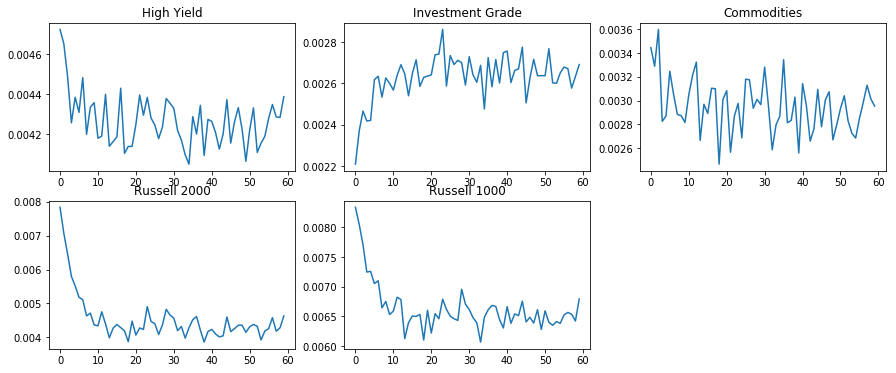

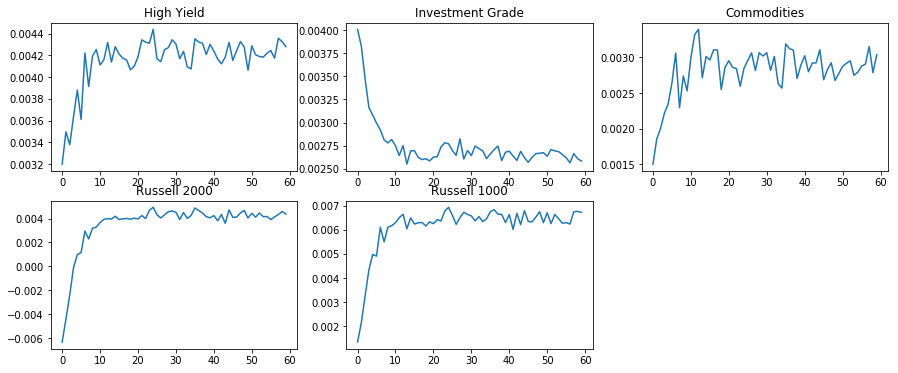

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
fig.delaxes(ax=axes[1,2])
for i, ax in enumerate(axes.flat[:5]):
    ax.plot(ret1[:, i, :].mean(axis=0))
    ax.set_title(colNames[i])
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
fig.delaxes(ax=axes[1,2])
for i, ax in enumerate(axes.flat[:5]):
    ax.plot(ret2[:, i, :].mean(axis=0))
    ax.set_title(colNames[i])
plt.show()

## Optimal asset allocation

We are now ready to find the optimal asset allocation for a portfolio with investment opportunities in these five asset classes including a sixth class of the risk free asset.

To take risk aversion into account, we consider a power utility function as below:

$$ u(W) = \frac{W^{1-\gamma}}{1-\gamma}, $$

where $W$ being wealth is given by:

$$
W = (1 - \omega'\iota) \exp\left\{T\cdot RF\right\} + \omega' \exp\left\{ \left(\mathbf{R} + RF \right) \iota\right\},
$$

where $\iota = (1, 1, \dots, 1)'$ is a column unit vector matching the dimension of $\omega$ and where in turn the weights $\omega$ allocated to each asset is:

$$
\omega' = \begin{pmatrix} \omega_{HY}, \omega_{IG}, \dots, \omega_{R1} \end{pmatrix},
$$

and the returns matrix $\mathbf{R}$ is given by:
$$
\mathbf{R} = 
\begin{pmatrix}
    r^{HY}_1 & r^{HY}_2 & \dots & r^{HY}_{12} \\
    r^{IG}_1 & r^{IG}_2 & \dots & r^{IG}_{12} \\
    \vdots   & \vdots   & \ddots& \vdots      \\
    r^{R1}_1 & r^{R1}_2 & \dots & r^{R1}_{12}
\end{pmatrix}.
$$

To solve the problem, we use a constrained solver. We have the optimal allocation solves the following problem:

$$\max_{\omega} u(W), \quad \text{st. } \omega_i \in [0,1] \forall i, \quad \sum_i \omega_i = 1.$$

The function `check_sum` below ensures the latter constraint, whereas the `bnds` vector allows to check the prior constraint.

In [22]:
def check_sum(weights):
    return np.sum(weights) - 1.0

def boundedOptimiser(f, w, args, ApB, method='SLSQP'):
    bnds = tuple(zip(np.zeros(ApB), np.ones(ApB)))
    cons = ({'type': 'eq', 'fun': check_sum})
    res = opt.minimize(
        f, w, args=args, bounds=bnds, constraints=cons, method=method
    )
    return res

@jit(nopython=True)
def expectedUtilityMult(w, returns, rf, g, A, T):
    rfCR = np.exp(T * rf)  # rfCR: risk free compounded return
    denominator = 1 - g
    rCR = np.exp(np.sum(returns, axis=2))*rfCR  # rCR:  risky compounded return
    numerator = (w[A] * rfCR + np.sum(w[:A] * rCR, axis=1)) ** (1 - g)
    return -np.mean(numerator / denominator) * 100000

To solve the problem, we need to define a couple variables:

* w: set of 6 standardised weights, one for each asset including the risk free
* g: a degree of risk aversion

In addition, to loop over this, we may extend $g$ to a whole vector, same for maturities and start states.

In [23]:
maturities = np.array([3, 6, 9, 10, 12, 24, 36, 48, 60])
start_states = [1, 2]
gamma = [3,5,7,9]

# Labelling for data frames
labels = np.hstack((colNames, 'Risk Free'))
abbrev = ['HY', 'IG', 'C', 'R2', 'R1', 'RF']

# Assets to allocate weights to
a = len(labels)  # 6

# 6 standardised random weights on the unit interval
w = np.random.random(a)
w /= np.sum(w)

# Non-simulated risk free rate of return in percent
rf = 0.003

# A matrix of weights for each asset for each maturity (3 x 6)
weights = np.squeeze(list(zip(
    [np.repeat(w[i], len(maturities)) for i in range(len(w))]
))).T

# Technicality: dictionary that can contain solutions for all states and gammas
ws = {s: 
      {g: pd.DataFrame(weights.copy(), index=maturities, columns=abbrev)
       for g in gamma}
      for s in start_states}

# Technicality: Lists that contains returns of maturities 3, 6 and 12 months
R1 = [ret1[:, :, :mat] for mat in maturities]
R2 = [ret2[:, :, :mat] for mat in maturities]
R = {0: R1,
     1: R2}

# Looping; j=[0,1], s=[1,2], gamma=[3,5,7,9], i=[0,1,2], mat=[3,6,9]
for j, s in enumerate(start_states):
    print 'start: {}'.format(s)
    for g in gamma:
        print 'gamma: {}'.format(g)
        for i, mat in enumerate(maturities):
            args = R[j][i], rf, g, a-1, mat
            results = boundedOptimiser(expectedUtilityMult, w, args, a)
            print 'weights for {} months: {}'.format(
                mat,
                np.round(results.x, 4)
            )
            ws[s][g].iloc[i,:] = np.round(results.x, 4)

('start: ', 1)
('gamma: ', 3)
('weights: ', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('weights: ', array([  5.00000000e-04,   2.20000000e-03,   3.00000000e-04,
         1.40000000e-03,   9.99300000e-01,   5.00000000e-04]))
('weights: ', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('weights: ', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('weights: ', array([ 0.0105,  0.    ,  0.    ,  0.    ,  0.9895,  0.    ]))
('weights: ', array([ 0.1304,  0.    ,  0.0214,  0.    ,  0.8481,  0.    ]))
('weights: ', array([ 0.1562,  0.    ,  0.0368,  0.    ,  0.807 ,  0.    ]))
('weights: ', array([ 0.1729,  0.    ,  0.0366,  0.    ,  0.7905,  0.    ]))
('weights: ', array([ 0.1874,  0.    ,  0.0354,  0.    ,  0.7773,  0.    ]))
('gamma: ', 5)
('weights: ', array([ 0.1207,  0.    ,  0.0057,  0.    ,  0.8736,  0.    ]))
('weights: ', array([ 0.2453,  0.    ,  0.0369,  0.    ,  0.7177,  0.    ]))
('weights: ', array([ 0.307 ,  0.    ,  0.0595,  0.    ,  0.6335,  0.    ]))
('weights: ', array([ 0.3341,  0.    ,  0.

### No intuition here, skip to plots

We want to plot these as time series. To this end we generate new dataframes that are designed for plotting.

In [34]:
asset_weights = {
    'aw1': {},
    'aw2': {}
}

for j, aw in enumerate(asset_weights):
    for i, a in enumerate(abbrev):
        asset_weights[aw][a] = pd.DataFrame(
            (ws[j+1][g].iloc[:,i] for g in gamma),
            index=gamma,
            columns=maturities
        ).T
    print '\n {}, Start state is {}: (maturities down, gamma out)'.format(
        abbrev[0],
        j+1)
    display(asset_weights[aw][abbrev[0]])

('HY', 'Start state is 1: (maturities down, gamma out)')


,3,5,7,9
3,0.0000,0.1207,0.3501,0.4777
6,0.0005,0.2453,0.4302,0.5102
9,0.0000,0.3070,0.4457,0.3824
10,0.0000,0.3341,0.4301,0.3681
12,0.0105,0.3483,0.3889,0.3355
24,0.1304,0.3655,0.3005,0.2602
36,0.1562,0.3301,0.2715,0.2347
48,0.1729,0.3199,0.2653,0.2312
60,0.1874,0.3172,0.2604,0.2228


('HY', 'Start state is 2: (maturities down, gamma out)')


,3,5,7,9
3,0.0391,0.0179,0.0061,0.0000
6,0.0403,0.0202,0.0121,0.0073
9,0.0810,0.0515,0.0387,0.0313
10,0.0994,0.0647,0.0498,0.0415
12,0.1129,0.0767,0.0607,0.0517
24,0.2302,0.1629,0.1316,0.1133
36,0.2598,0.1907,0.1570,0.1372
48,0.2896,0.2162,0.1786,0.1563
60,0.3029,0.2322,0.1912,0.1655


### Allocations

The plots below show the allocation to each asset for each investment horizon, for each starting state and for each degree of risk aversion.

Solid lines indicate we are starting in state 1, dashed lines indicate we are starting in state 2.

**HY** Has a high investment degree when starting in state 1, when there is low risk tolerance ($\gamma = 9$) and the investment horizon is short. When there is high risk tolerance ($\gamma = 3$) there is no initial allocation, as this has been put into **R1**. Starting in state 2 has little allocation even for a 1 year investment, as **IG** takes the prize here.

**IG** is the "safe choice". This is reflected in a heavy allocation when starting in the crash state (2). When starting in the bull state, a positive allocation eventually gets placed into **IG**, in particular for the low risk tolerance ($\gamma= 9$), as the probability of entering into state 2 increases.

**R1** is the risky bet. When all is good (starting in state 1) and when risk tolerance is high, a heavy load is entered into this asset class. When the state of the world is bad (state 2), a long horizon is needed to warrant positive allocation to this index.

**The rest** has effectively no allocation.

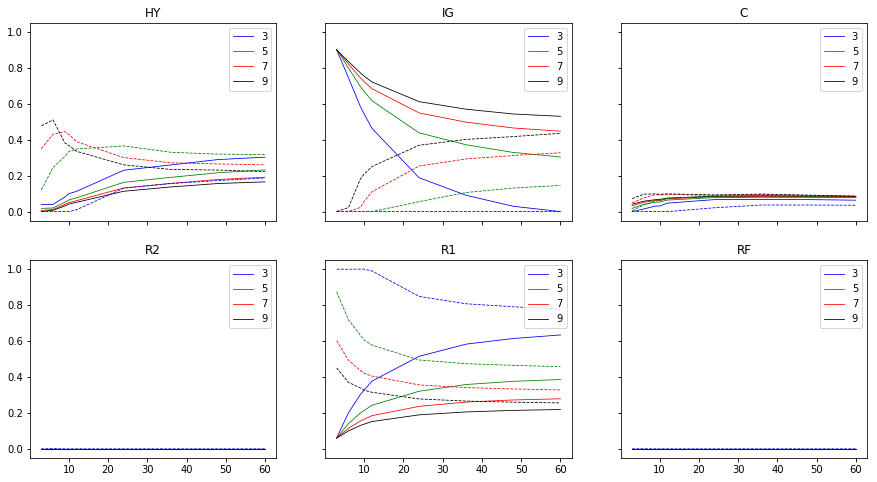

In [35]:
colors = np.array(['blue', 'green', 'red', 'black'])
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 8)
)
for ax, a in zip(axes.flat, abbrev):
    ax.set_title(a)
    asset_weights['aw1'][a].plot(
        legend=True, ax=ax, color=colors, linewidth=0.8
    )
    asset_weights['aw2'][a].plot(
        legend=False, ax=ax, color=colors, linewidth=0.8, linestyle='dashed'
    )
plt.show()

##### Allocations as bar charts (skip if short of time)

We now have the allocations for each asset conditional on the investment horizon and the risk sensitivity. We are ready to see what kind of compounded return and utility, respectively, we would make, when investing according to this investment strategy.

First, the image above gives some indication. But since we only care about three investment horizons, we will make bar charts instead. This removes the illusion of a gradual decline between horizons 3, 6 and 12 months.

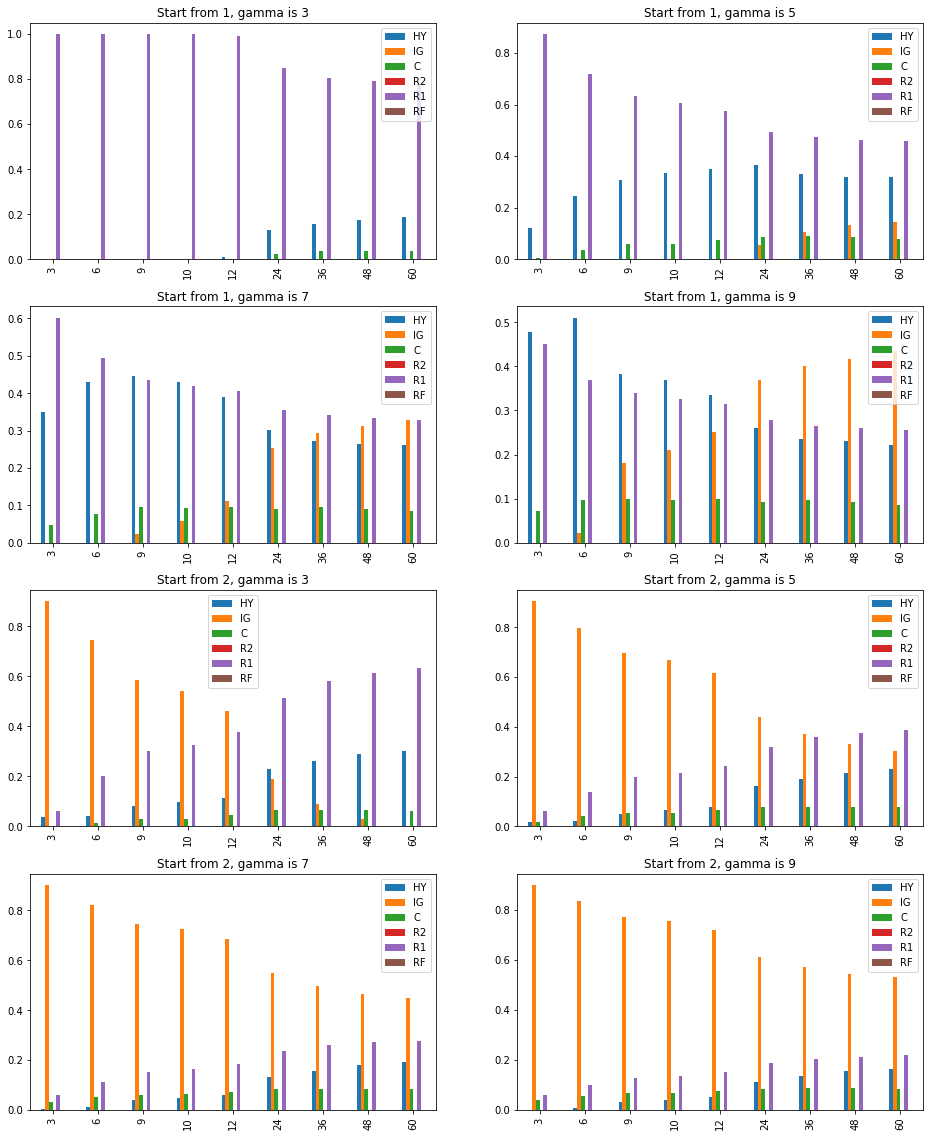

In [36]:
sts = np.hstack((np.repeat(1, len(gamma)), np.repeat(2, len(gamma))))
gms = np.hstack((gamma,gamma))

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,20))
for s, g, ax in zip(sts, gms, axes.flat):
    ws[s][g].plot.bar(ax=ax)
    ax.set_title('Start from {}, gamma is {}'.format(s, g))
plt.show()

### Out of sample test

We now consider the year of 2018. We stopped estimating parameters up until December 2017, meaning any strategies concerning the period after December 2017 are out of sample.

We will take the strategies above and compare them with the optimal allocation as computed by a constrained solver over the actual months of 2018.

First, we take a look at the data.

,RF
Date,
2014-01-31,0.0000
2014-02-28,0.0000
2014-03-31,0.0000
2014-04-30,0.0000
2014-05-30,0.0000
2014-06-30,0.0000
2014-07-31,0.0000
2014-08-29,0.0000
2014-09-30,0.0000


,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
Date,,,,,
2014-01-31,0.0100,0.0210,0.0060,-0.0251,-0.0295
2014-02-28,0.0230,0.0133,0.0635,0.0490,0.0494
2014-03-31,0.0054,0.0037,0.0071,-0.0038,0.0093
2014-04-30,0.0093,0.0149,0.0271,-0.0366,0.0077
2014-05-30,0.0122,0.0166,-0.0262,0.0110,0.0257
2014-06-30,0.0113,0.0038,0.0089,0.0548,0.0255
2014-07-31,-0.0104,0.0024,-0.0481,-0.0594,-0.0133
2014-08-29,0.0187,0.0173,-0.0075,0.0514,0.0435
2014-09-30,-0.0182,-0.0115,-0.0613,-0.0594,-0.0147


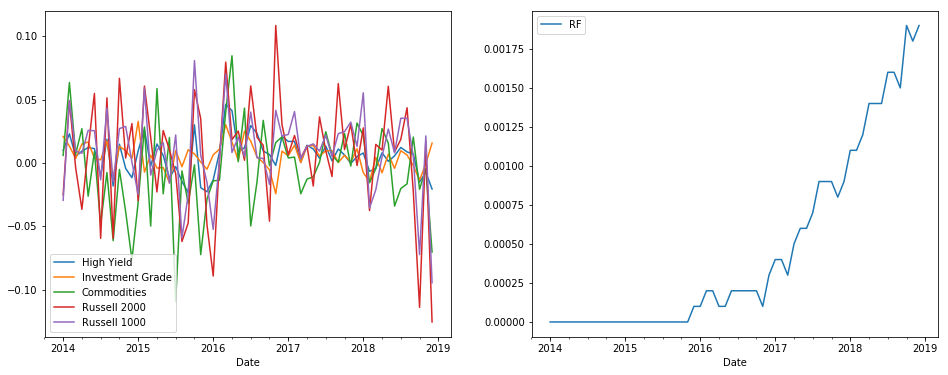

In [44]:
display(rf_data.iloc[366:378])
rf_array = np.array(rf_data.iloc[366:,0])

returns_14 = excess_returns.iloc[365:]
returns_14 = returns_14.add(rf_array, axis=0)
display(returns_14[:12])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
returns_14.plot(ax=ax1)
rf_data.iloc[366:].plot(ax=ax2)
plt.show()

In [45]:
pd.options.display.float_format = '{:.4f}'.format

In [46]:
# Extend table with the risk free rate
returns_14['RF']=rf
CR = np.exp(returns_14).cumprod()
display(CR.round(4))

,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000,RF
Date,,,,,,
2014-01-31,1.0100,1.0212,1.0060,0.9752,0.9710,1.0030
2014-02-28,1.0336,1.0349,1.0719,1.0243,1.0201,1.0060
2014-03-31,1.0391,1.0387,1.0796,1.0203,1.0297,1.0090
2014-04-30,1.0488,1.0543,1.1092,0.9837,1.0376,1.0121
2014-05-30,1.0617,1.0719,1.0805,0.9946,1.0647,1.0151
2014-06-30,1.0738,1.0760,1.0902,1.0506,1.0922,1.0182
2014-07-31,1.0626,1.0786,1.0390,0.9900,1.0777,1.0212
2014-08-29,1.0827,1.0975,1.0313,1.0422,1.1256,1.0243
2014-09-30,1.0632,1.0849,0.9700,0.9821,1.1092,1.0274


### Performance

Our portfolio is quickly providing a positive return, with a slight dip in March and April. We end the year with a loss due to erratic stock markets in December. We see that is is the Russell 1000 index which is the primary source of the loss.

In [47]:
print('State is 1, gamma is 3')
display(ws[1][3])

print('State is 2, gamma is 5')
display(ws[2][5])

State is 1, gamma is 3


,HY,IG,C,R2,R1,RF
3,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
6,0.0005,0.0022,0.0003,0.0014,0.9993,0.0005
9,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
10,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
12,0.0105,0.0000,0.0000,0.0000,0.9895,0.0000
24,0.1304,0.0000,0.0214,0.0000,0.8481,0.0000
36,0.1562,0.0000,0.0368,0.0000,0.8070,0.0000
48,0.1729,0.0000,0.0366,0.0000,0.7905,0.0000
60,0.1874,0.0000,0.0354,0.0000,0.7773,0.0000


State is 2, gamma is 5


,HY,IG,C,R2,R1,RF
3,0.0179,0.9040,0.0178,0.0000,0.0603,0.0000
6,0.0202,0.7988,0.0408,0.0000,0.1402,0.0000
9,0.0515,0.6974,0.0524,0.0000,0.1986,0.0000
10,0.0647,0.6686,0.0529,0.0000,0.2137,0.0000
12,0.0767,0.6168,0.0641,0.0000,0.2425,0.0000
24,0.1629,0.4383,0.0784,0.0000,0.3204,0.0000
36,0.1907,0.3717,0.0798,0.0000,0.3579,0.0000
48,0.2162,0.3291,0.0792,0.0000,0.3755,0.0000
60,0.2322,0.3042,0.0778,0.0000,0.3857,0.0000


('Start is: ', 1)


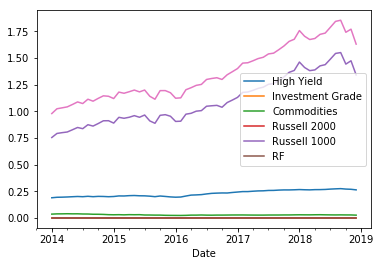

Date
2014-01-31   0.9796
2014-02-28   1.0246
2014-03-31   1.0333
2014-04-30   1.0424
2014-05-30   1.0648
2014-06-30   1.0888
2014-07-31   1.0736
2014-08-29   1.1144
2014-09-30   1.0958
2014-10-31   1.1223
2014-11-28   1.1461
2014-12-31   1.1419
2015-01-30   1.1205
2015-02-27   1.1811
2015-03-31   1.1701
2015-04-30   1.1845
2015-05-29   1.2002
2015-06-30   1.1832
2015-07-31   1.2005
2015-08-31   1.1420
2015-09-30   1.1141
2015-10-30   1.1949
2015-11-30   1.1952
2015-12-31   1.1753
2016-01-29   1.1236
2016-02-29   1.1272
2016-03-31   1.2034
2016-04-29   1.2223
2016-05-31   1.2444
2016-06-30   1.2532
2016-07-29   1.2997
2016-08-31   1.3090
2016-09-30   1.3159
2016-10-31   1.2997
2016-11-30   1.3438
2016-12-30   1.3725
2017-01-31   1.4019
2017-02-28   1.4531
2017-03-31   1.4565
2017-04-28   1.4751
2017-05-31   1.4958
2017-06-30   1.5082
2017-07-31   1.5394
2017-08-31   1.5466
2017-09-29   1.5791
2017-10-31   1.6137
2017-11-30   1.6569
2017-12-29   1.6772
2018-01-31   1.7587
2018-02-28   1.

('Start is: ', 2)


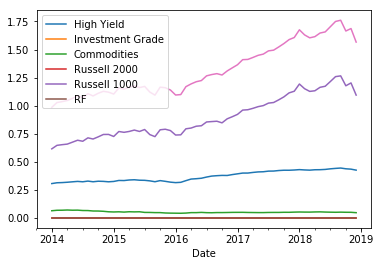

Date
2014-01-31   0.9850
2014-02-28   1.0275
2014-03-31   1.0357
2014-04-30   1.0456
2014-05-30   1.0648
2014-06-30   1.0865
2014-07-31   1.0707
2014-08-29   1.1066
2014-09-30   1.0864
2014-10-31   1.1103
2014-11-28   1.1277
2014-12-31   1.1201
2015-01-30   1.1033
2015-02-27   1.1578
2015-03-31   1.1471
2015-04-30   1.1630
2015-05-29   1.1761
2015-06-30   1.1608
2015-07-31   1.1713
2015-08-31   1.1211
2015-09-30   1.0937
2015-10-30   1.1645
2015-11-30   1.1597
2015-12-31   1.1392
2016-01-29   1.0947
2016-02-29   1.0986
2016-03-31   1.1691
2016-04-29   1.1935
2016-05-31   1.2131
2016-06-30   1.2235
2016-07-29   1.2654
2016-08-31   1.2769
2016-09-30   1.2851
2016-10-31   1.2731
2016-11-30   1.3091
2016-12-30   1.3371
2017-01-31   1.3644
2017-02-28   1.4096
2017-03-31   1.4118
2017-04-28   1.4294
2017-05-31   1.4482
2017-06-30   1.4591
2017-07-31   1.4880
2017-08-31   1.4943
2017-09-29   1.5231
2017-10-31   1.5533
2017-11-30   1.5884
2017-12-29   1.6068
2018-01-31   1.6755
2018-02-28   1.

In [48]:
# Out of sample weights: start: 1, gamma: 3, maturity: 60
oos_gamma = 3
wealth = {
    'w1': {},
    'w2': {}
}

for s, wi in enumerate(wealth):
    print('Start is: ', s+1)
    oos_weights=np.array(ws[s+1][oos_gamma].iloc[8,:]) # index 8 is month 60
    wealth[wi] = oos_weights*CR
    wealth[wi].plot()
    wealth[wi].sum(axis=1).plot()
    plt.show()
    # wealth at end of period
    display(wealth[wi].sum(axis=1))

### Introducing risk metrics

We can look at an underwater map and a max drawdown map of the portfolio. This will be useful to state how the portfolio performs not just from a perspective of returns, but equally importantly from a perspective of losses.

##### On maximum drawdown

Maximum drawdown is a measure in percent stating how much has been lost from peak to trough as a percentage of the peak, i.e.:

$$
\text{MD} = \frac{\hat p - \check p}{\hat p},
$$

where $\hat p$ is the peak of the portfolio/asset value and $\check p$ is the lowest value achieved. Below we show the 10 maximum drawdowns of each time series under consideration.

High Yield, max drawdown: -37.81 pct.


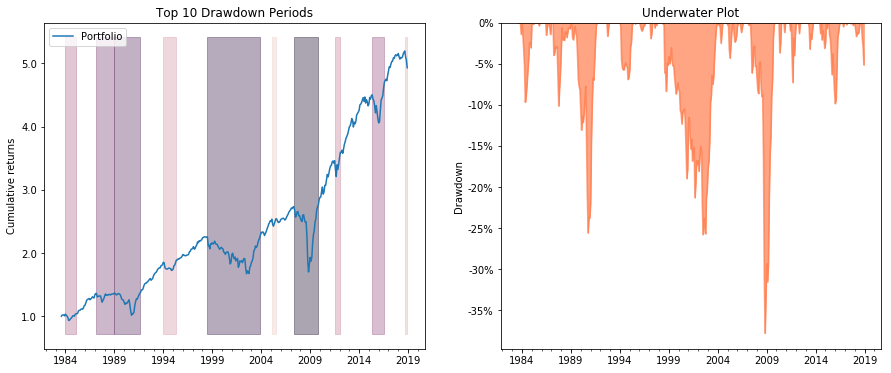

Investment Grade, max drawdown: -18.91 pct.


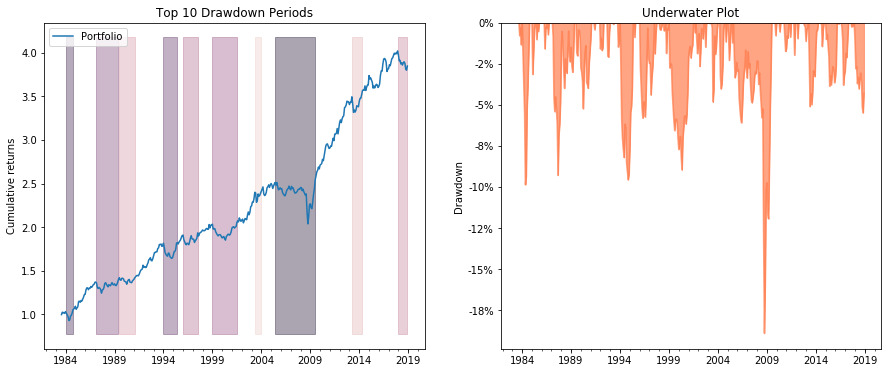

Commodities, max drawdown: -71.9 pct.


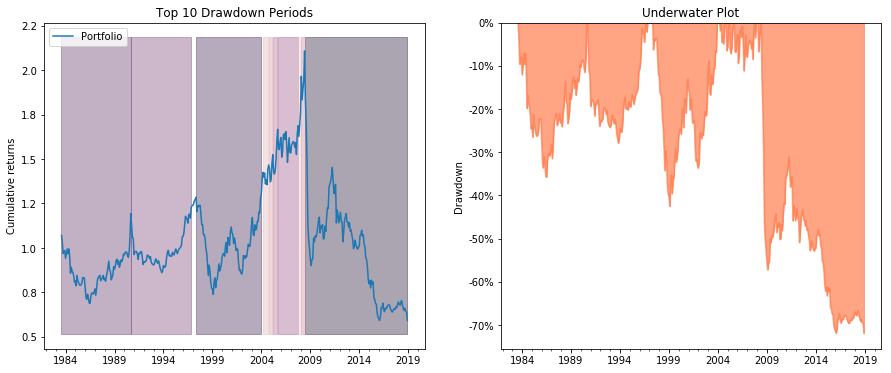

Russell 2000, max drawdown: -58.29 pct.


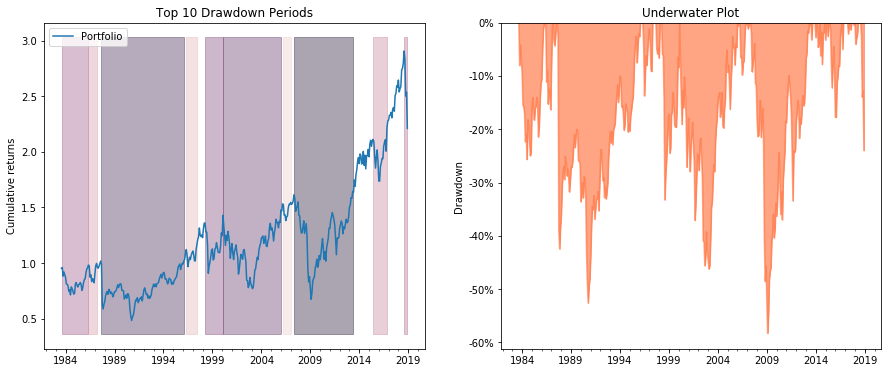

Russell 1000, max drawdown: -60.05 pct.


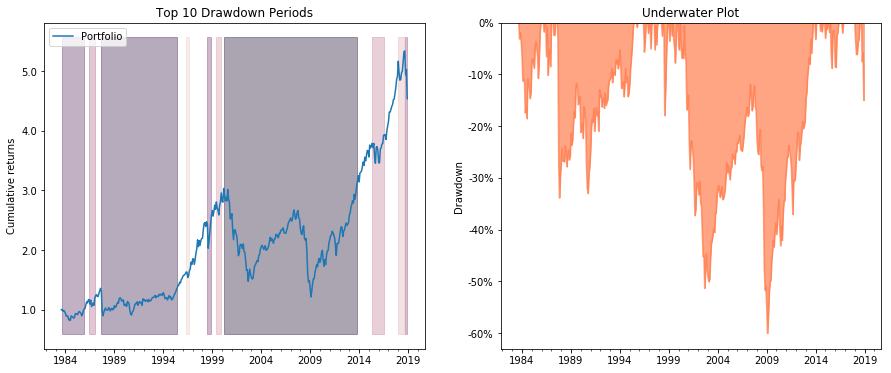

In [97]:
for l in colNames:
    print('{}, max drawdown: {} pct.'.format(l, round(ep.max_drawdown(excess_returns[l])*100, 2)))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    pf.plot_drawdown_periods(excess_returns[l], ax=ax1)
    pf.plot_drawdown_underwater(excess_returns[l], ax=ax2)
    plt.show()

##### Why is it important?

From the saying "steady does it", there is an implication that the worst that can be done is setbacks. This is because instead of making small returns continually, now you have to make up for something that is not there. In addition, losses are not linear. This can be seen by the following table.

| Loss | Required Gain |
|-----|-----|
| 10\% | 11\% |
| 25\% | 33\% |
| 50\% | 100\% |
| 75\% | 300\% |

That is, it becomes increasingly difficult to make up the returns. From a time perspective, we can make an assumption about returns to compute required years to make up.

Say the market makes a 11 pct. return on average. 

$$
K = K \cdot (1-x) \cdot (1 + 0.11)^n \\ 
\Leftrightarrow \frac{\log\left(\frac{1}{(1 - x)}\right)}{\log\left(1,11\right)} = n \\
\Leftrightarrow n = -\frac{\log\left(1-x\right)}{\log\left(1,11\right)}
$$

where $K$ is the initial wealth, $x$ is the percentage loss (e.g. left column in table above), $n$ is the amount of time in years. Note that logarithms $\log(\varepsilon)<0$ for $\varepsilon \in (0,1)$.

| Loss | Required Gain (approx.) | Time taken at 11 pct. (years) |
|-----|-----|-----|
| 10\% | 11\% | 1.01 |
| 25\% | 33\% | 2.75 |
| 50\% | 100\% | 6.64 |
| 75\% | 300\% | 13.28 |

##### Asset class performances
From the above underwater charts, we see that there is indeed evidence for bonds being safer investments, with Investment Grade dropping at most 18 pct. High Yields dropped twice as much, equities were even more sensitive and commodities have suffered the largest drawdown of all, nearing 70 pct. losses from their peak in 2008.

| Asset class | Approximate loss (pct.) | Recovery time (years) |
| ----------- | ----------------------- | --------------------- |
| High Yield  | 37.81 | 4.55 |
| Investment Grade | 18.91 | 2.01 |
| Commodities | 71.9 | 12.16 |
| Russell 2000 | 58.29 | 8.38 |
| Russell 1000 | 60.05 | 8.79 |

### Drawdown on the ex ante optimal portfolio

We are now ready to consider not the asset classes separately, but the optimal portfolio of the combined assets.

Start is: 1
Max drawdown: -12.17 pct.


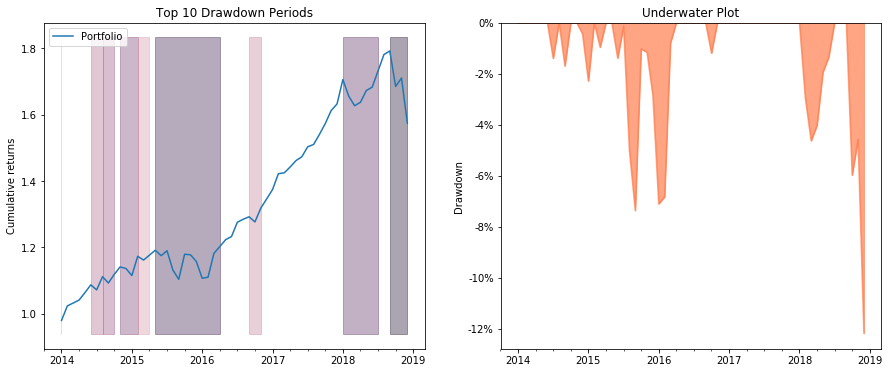

Start is: 2
Max drawdown: -10.89 pct.


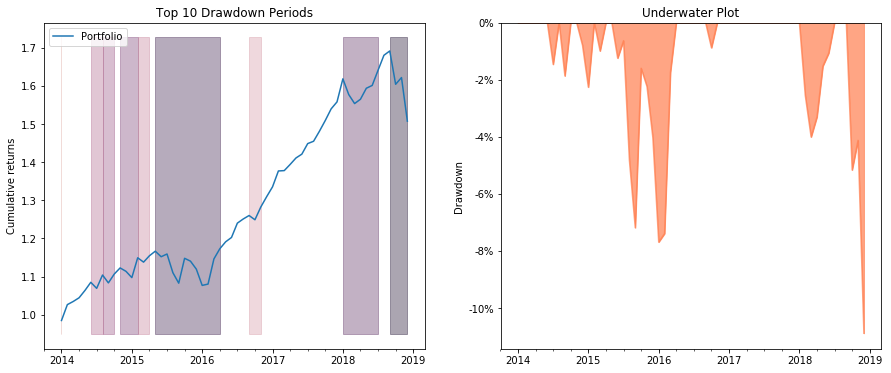

In [99]:
# Out of sample weights: start: 1, gamma: 3, maturity: 60
oos_gamma = 3
returns_by_weights = {
    'w1': {},
    'w2': {}
}

for s, wi in enumerate(wealth):
    print('Start is: {}'.format(s+1))
    oos_weights=np.array(ws[s+1][oos_gamma].iloc[8,:]) # index 8 is month 60
    
    returns_by_weights[wi] = oos_weights*returns_14
    rbw = returns_by_weights[wi].sum(axis=1)
    md = round(ep.max_drawdown(rbw)*100, 2)
    
    print('Max drawdown: {} pct.'.format(md))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    pf.plot_drawdown_periods(rbw, ax=ax1)
    pf.plot_drawdown_underwater(rbw, ax=ax2)
    plt.show()

### Relatively brief recovery periods

From the above we see that December 2018 is associated with large drawdowns. Below is a table of drawdowns and recovery times.

| Starting state | Max drawdown (pct.) | Recovery time (years) |
| ----- | ----- | ----- |
| State 1 | 12.17 | 1.24 |
| State 2 | 10.89 | 1.10 |

We note that, believing we are starting in a crash state seems to make us more wary, investing on the more careful side with regards to max drawdown. We would however suffer larger losses in 2016. Later we will consider different investment horizons to see if this would change with a shorter investment horizon.

With the above results, we could perhaps expect lower performance of the portfolio initiated in state 2. That is in fact what we see below.

In [105]:
oos_weights1=np.array(ws[1][oos_gamma].iloc[8,:])
oos_weights2=np.array(ws[2][oos_gamma].iloc[8,:])

# CR was a table of cummulated returns over all periods,
# cr is simply the cummulated return in the FINAL period.
cr = np.exp(np.sum(returns_14, axis = 0))

wr1 = oos_weights1*cr
wr2 = oos_weights2*cr

crw1 = np.round(np.sum(wr1), 4)
crw2 = np.round(np.sum(wr2), 4)

cru1 = round(np.sum(wr1)**(1-oos_gamma)/(1-oos_gamma), 4)
cru2 = round(np.sum(wr2)**(1-oos_gamma)/(1-oos_gamma), 4)

print('Compounded weighted return for state 1 is: {}'.format(crw1))
print('Compounded weighted return for state 2 is: {}'.format(crw2))

print('Corresponding utility for state 1 is: {}'.format(cru1))
print('Corresponding utility for state 2 is: {}'.format(cru2))

Compounded weighted return for state 1 is: 1.6314
Compounded weighted return for state 2 is: 1.5662
Corresponding utility for state 1 is: -0.1879
Corresponding utility for state 2 is: -0.2038


### A look at final wealth and utility before comparison

To compare our simulated portfolio with some benchmark, we can now take the actual data from 2014 and ahead and find the optimal allocation there.

We note that the actual data should catch the slump in December 2018 and other slumps, and we thus expect to see a different allocation which outperforms our simulated allocation.

What is interesting to see is how the performance compares over the course of the year. We update the expected utility function from before, as we have extended the data frame to include the risk free asset.

In [108]:
# @jit(nopython=True)
def expectedUtilityMult2(w, returns, g):
    # CR: compounded return
    CR = np.exp(np.sum(returns, axis=0))
    
    numerator = np.sum(w * CR) ** (1 - g)
    denonimator = 1 - g
    return -numerator / denonimator * 100000

# Test to see if we achieve the "correct" utility
print(-round(expectedUtilityMult2(oos_weights1, returns_14, oos_gamma)/100000,4))
print(-round(expectedUtilityMult2(oos_weights2, returns_14, oos_gamma)/100000,4))

-0.1879
-0.2038


### Ex post optimal weights

We are now ready to make the constrained optimisation yet again:

In [73]:
# [A]ssets [p]lus [B]ank account
ApB = 6

# Standardised weights on the unit interval
w = np.random.random(ApB)
w /= np.sum(w)

# Arguments other than w to be passed to expectedUtilityMult
args = returns_14, oos_gamma

# Function over which to optimise
f = expectedUtilityMult2

# Results
oos_result = boundedOptimiser(f, w, args, ApB, method='SLSQP')
opt_weights = oos_result.x
np.round(opt_weights, 4)

array([ 0.,  0.,  0.,  0.,  1.,  0.])

The allocation has 100 pct. allocation into the stock *(risk free asset for 2018 alone)*. To see how this looks, we can multiply over our actual return data for 2014 and forward.

Date
2014-01-31   0.9710
2014-02-28   1.0201
2014-03-31   1.0297
2014-04-30   1.0376
2014-05-30   1.0647
2014-06-30   1.0922
2014-07-31   1.0777
2014-08-29   1.1256
2014-09-30   1.1092
2014-10-31   1.1397
2014-11-28   1.1731
2014-12-31   1.1739
2015-01-30   1.1450
2015-02-27   1.2148
2015-03-31   1.2033
2015-04-30   1.2155
2015-05-29   1.2351
2015-06-30   1.2156
2015-07-31   1.2427
2015-08-31   1.1715
2015-09-30   1.1428
2015-10-30   1.2390
2015-11-30   1.2468
2015-12-31   1.2279
2016-01-29   1.1651
2016-02-29   1.1680
2016-03-31   1.2528
2016-04-29   1.2633
2016-05-31   1.2892
2016-06-30   1.2957
2016-07-29   1.3488
2016-08-31   1.3544
2016-09-30   1.3593
2016-10-31   1.3365
2016-11-30   1.3932
2016-12-30   1.4232
2017-01-31   1.4556
2017-02-28   1.5158
2017-03-31   1.5209
2017-04-28   1.5408
2017-05-31   1.5642
2017-06-30   1.5789
2017-07-31   1.6139
2017-08-31   1.6224
2017-09-29   1.6604
2017-10-31   1.7020
2017-11-30   1.7578
2017-12-29   1.7810
2018-01-31   1.8823
2018-02-28   1.

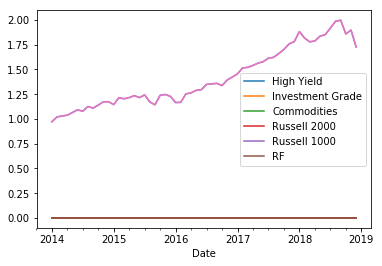

In [74]:
opt_wealth = opt_weights*CR
display(opt_wealth.sum(axis=1))

opt_wealth.plot()
opt_wealth.sum(axis=1).plot()

As we note, 100 pct. investment in the Russell 1000 outperforms our suggested portfolio. The return is 72.7 pct. versus 56.7 pct. in our ex ante optimal portfolio.

From the tables we see that the ex ante optimal allocations have large returns of 7 pct. at one point, before crashing in December. The ex post optimal allocation never achieves this higher return, but it ends with a positive return as the risk free rate is not affected by neither the first tumble in October and the second free fall in December.

We can compare the two in the same plot to get a visual appreciation for these results:

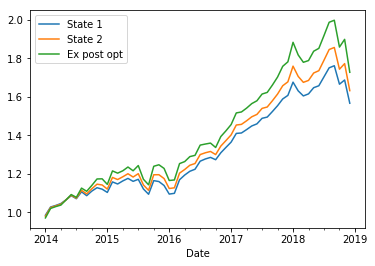

In [77]:
wealth['w1'].sum(axis=1).plot(label='State 1')
wealth['w2'].sum(axis=1).plot(label='State 2')
opt_wealth.sum(axis=1).plot(label='Ex post opt')
plt.legend()
plt.show()

#### Maximum drawdown on the two portfolios

We can compute max drawdown and the underwater plot on the two portfolios again.

Start is: 1
Max drawdown is: -0.1217
Final return is: 1.6314


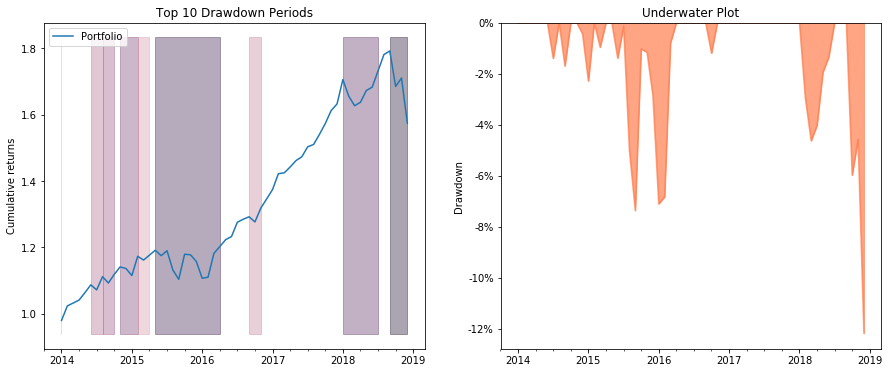

Start is: 2
Max drawdown is: -0.1089
Final return is: 1.5662


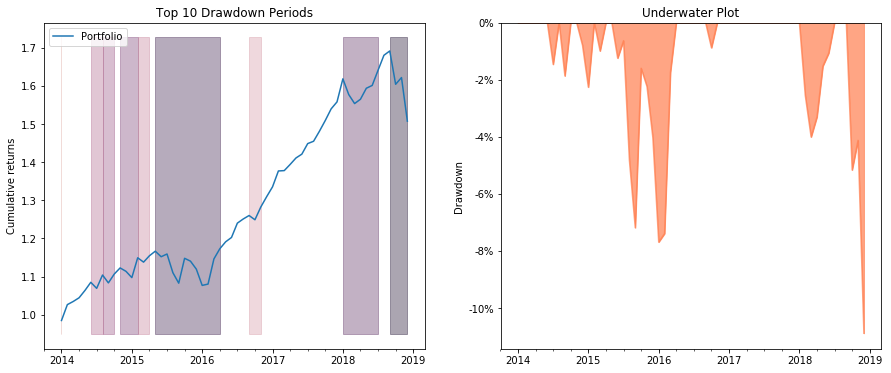

Ex post optimal portfolio
Max drawdown is: -0.142
Final return is: 1.7267


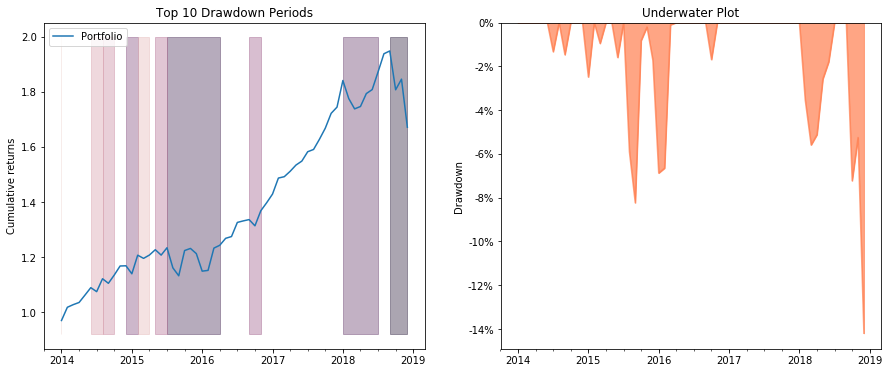

In [124]:
for s, wi in enumerate(wealth):
    oos_weights=np.array(ws[s+1][oos_gamma].iloc[8,:]) # index 8 is month 60
    returns_by_weights[wi] = oos_weights*returns_14
    rbw = returns_by_weights[wi].sum(axis=1)
    rbwt = oos_weights*cr
    print('Start is: {}'.format(s+1))
    print('Max drawdown is: {}'.format(round(ep.max_drawdown(rbw),4)))
    print('Final return is: {}'.format(round(np.sum(rbwt), 4)))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    pf.plot_drawdown_periods(rbw, ax=ax1)
    pf.plot_drawdown_underwater(rbw, ax=ax2)
    plt.show()

returns_by_weights_opt = opt_weights*returns_14
rbwo = returns_by_weights_opt.sum(axis=1)
rbwt = opt_weights*cr
print('Ex post optimal portfolio')
print('Max drawdown is: {}'.format(round(ep.max_drawdown(rbwo), 4)))
print('Final return is: {}'.format(round(np.sum(rbwt), 4)))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
pf.plot_drawdown_periods(rbwo, ax=ax1)
pf.plot_drawdown_underwater(rbwo, ax=ax2)
plt.show()

### Ex post optimal has larger maximum drawdown

What we find, perhaps not surprisingly, is that the ex-post optimal allocation has the largest drawdown.

The reason this does not surprise us is that the ex-post optimal allocation is concentrated on one asset, and tolerates large drawdowns because the entire process is known. Consequently, we would accept an immensely larger drawdown, if we know we are rewarded by a larger cummulated return over the entire horizon.

It is in fact the case, that returns are better, beating the best out of sample portfolio by almost 10 percentage points over the investment horizon.

#### Repeat for other risk tolerances

We can now repeat this same exercise for other risk tolerance levels.

In [92]:
ws[1][3]

,HY,IG,C,R2,R1,RF
3,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
10,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
12,0.0430,0.0000,0.0000,0.0000,0.9570,0.0000
24,0.1818,0.0000,0.0371,0.0000,0.7811,0.0000
36,0.2361,0.0000,0.0416,0.0000,0.7223,0.0000
48,0.2628,0.0000,0.0426,0.0000,0.6946,0.0000
60,0.2716,0.0000,0.0424,0.0000,0.6861,0.0000


Gamma=3
Final return is: 1.63
Max drawdown is: -12.17
Optimal return is: 1.73
Optimal max drawdown is: -14.2


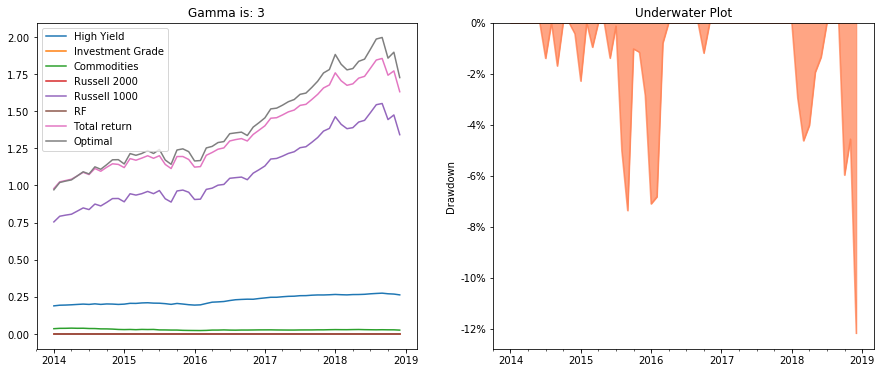

Gamma=5
Final return is: 1.49
Max drawdown is: -8.59
Optimal return is: 1.73
Optimal max drawdown is: -14.2


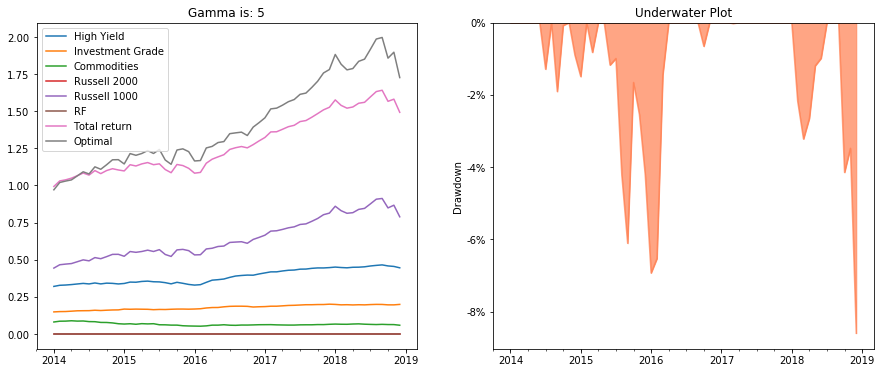

Gamma=7
Final return is: 1.44
Max drawdown is: -6.54
Optimal return is: 1.73
Optimal max drawdown is: -14.2


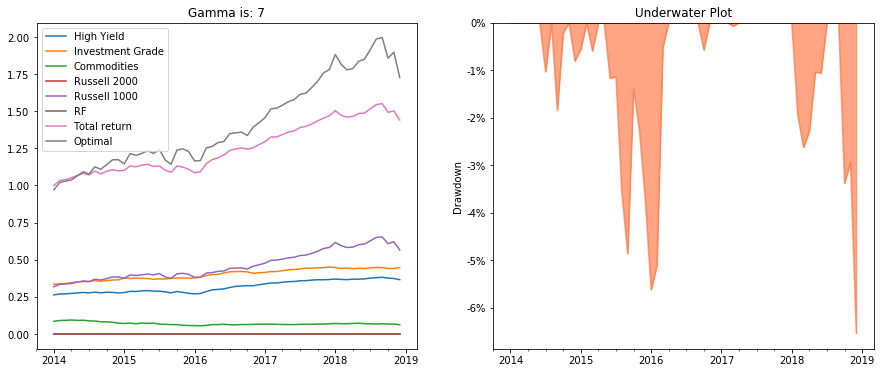

Gamma=9
Final return is: 1.41
Max drawdown is: -5.36
Optimal return is: 1.73
Optimal max drawdown is: -14.2


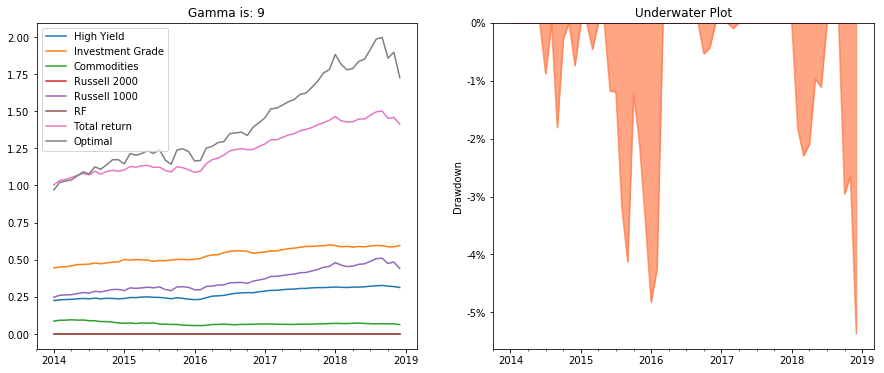

In [157]:
# [o]ut of sample [w]eights, gamma = 3 ==> [o][w]3
# Out of sample weights: start: 1, gamma: 3, maturity: 60 (index 8, see .iloc[])
os1, os2 = 1, 2

oos_weights=[np.array(ws[os1][osg].iloc[8,:]) for osg in gamma]

# wealth at end of period
orets = [oos_weights[i]*returns_14 for i in range(len(gamma))]
owealth = [oos_weights[i]*CR for i in range(len(gamma))]

# Optimal portfolio
opt_weights=oos_result.x
rbw_opt = opt_weights*CR
rbwo = opt_weights*returns_14
rbwo = rbwo.sum(axis=1)
rbwt = opt_weights*cr

for i in range(len(gamma)):
    print('Gamma={}'.format(gamma[i]))
    print('Final return is: {}'.format(
          owealth[i].iloc[len(owealth[i])-1,:].sum().round(2)))
    print('Max drawdown is: {}'.format(
        round(ep.max_drawdown(orets[i].sum(axis=1))*100, 2)
    ))
    print('Optimal return is: {}'.format(round(np.sum(rbwt), 2)))
    print('Optimal max drawdown is: {}'.format(round(ep.max_drawdown(rbwo)*100, 2)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # each times series separately
    owealth[i].plot(ax=ax1)
    
    # The total
    owealth[i].sum(axis=1).plot(ax=ax1, label='Total return')
    
    # The ex-post optimal portfolio
    rbw_opt.sum(axis=1).plot(ax=ax1, label='Optimal')
    
    # the title over the plot and removal of "date" for x-axis title
    ax1.set_title('Gamma is: {}'.format(gamma[i]))
    ax1.set_xlabel('')
    ax1.legend()
    
    # Drawdown underwater plot
    pf.plot_drawdown_underwater(orets[i].sum(axis=1), ax=ax2)
    plt.show()

##### Part result

The effect of $\gamma$ is exactly as expected. We note that larger risk aversion (higher value of $\gamma$) leads to:

1. Reduced return
2. Reduced maximum drawdown

We also see that:

1. Portfolios are weakly outperforming the ex-post optimal portfolio on the short horizon
2. After mid-2014 no portfolios outperform the ex-post optimal portfolio at any point in the time horizon

At a long horizon of 5 years, the ex-post optimal portfolio is entirely invested in stocks, so the result that a diversified portfolio is never better at any point than the concentrated portfolio does present a surprise to us.

In [151]:
opt_weights=np.zeros((4,6))
for i, g in enumerate([3,5,7,9]):
    args = returns_18, g
    oos_result = boundedOptimiser(f, w, args, ApB, method='SLSQP')
    opt_weights[i] = np.round(oos_result.x, 4)
    print(opt_weights[i])

[ 0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  1.  0.]


#### Believing we start in a crash state

Believing we start in state 2 should make us more risk averse. Consequently, we should be able to get closer to the performance of the risk free asset.

Gamma=3
Final return is: 1.57
Max drawdown is: -10.89
Optimal return is: 1.73
Optimal max drawdown is: -14.2


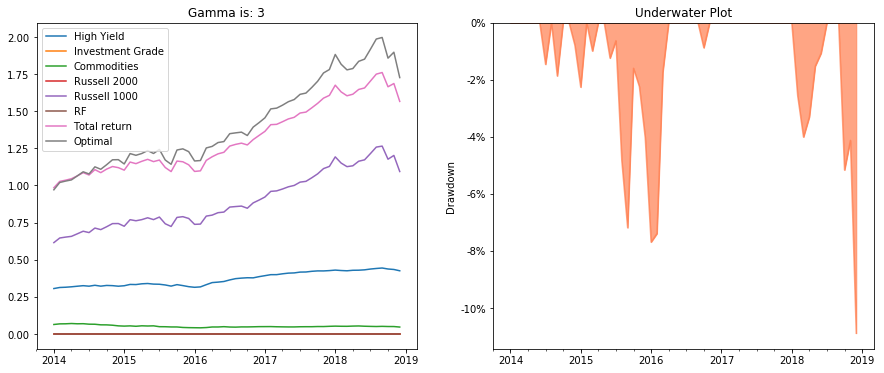

Gamma=5
Final return is: 1.47
Max drawdown is: -7.19
Optimal return is: 1.73
Optimal max drawdown is: -14.2


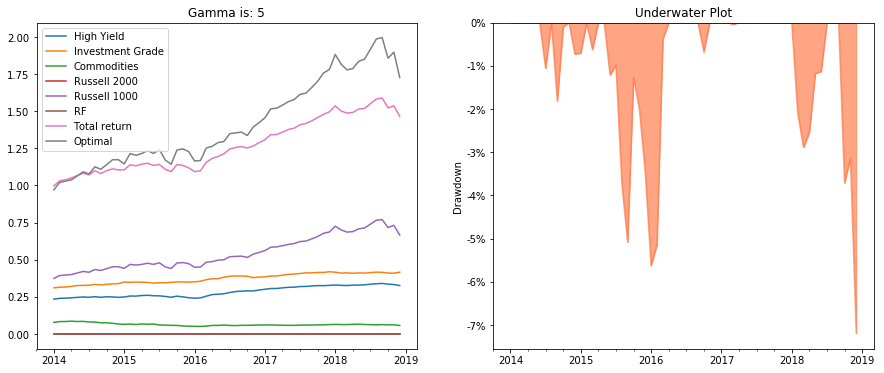

Gamma=7
Final return is: 1.42
Max drawdown is: -5.52
Optimal return is: 1.73
Optimal max drawdown is: -14.2


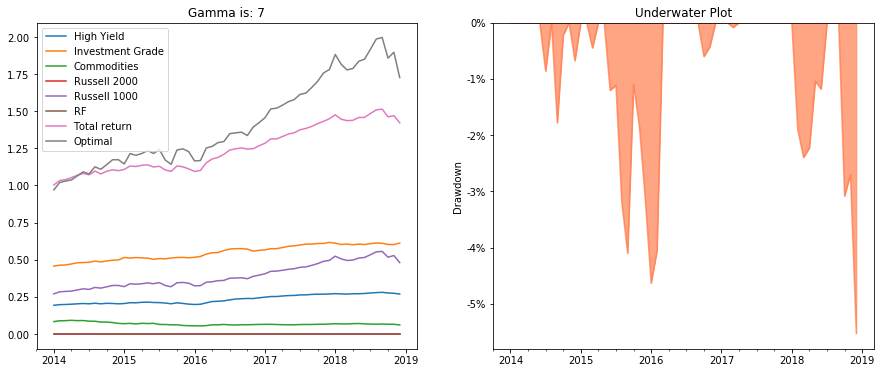

Gamma=9
Final return is: 1.4
Max drawdown is: -4.57
Optimal return is: 1.73
Optimal max drawdown is: -14.2


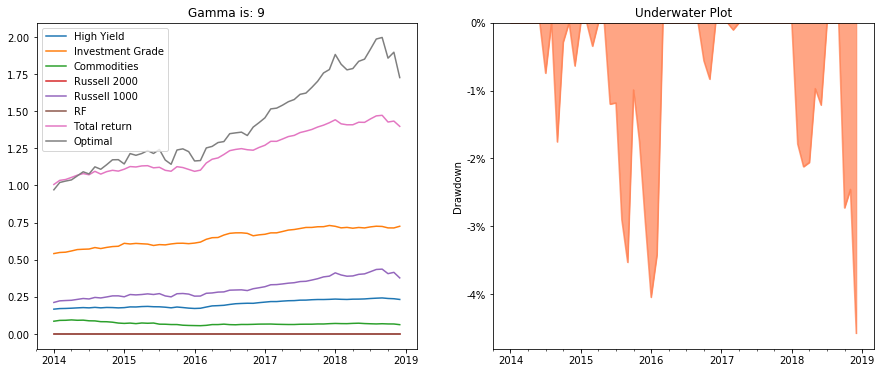

In [158]:
# [o]ut of sample [w]eights, gamma = 3 ==> [o][w]3
# Out of sample weights: start: 1, gamma: 3, maturity: 60 (index 8, see .iloc[])
os1, os2 = 1, 2

oos_weights=[np.array(ws[os2][osg].iloc[8,:]) for osg in gamma]

# wealth at end of period
orets = [oos_weights[i]*returns_14 for i in range(len(gamma))]
owealth = [oos_weights[i]*CR for i in range(len(gamma))]

# Optimal portfolio
opt_weights=oos_result.x
rbw_opt = opt_weights*CR
rbwo = opt_weights*returns_14
rbwo = rbwo.sum(axis=1)
rbwt = opt_weights*cr

for i in range(len(gamma)):
    print('Gamma={}'.format(gamma[i]))
    print('Final return is: {}'.format(
          owealth[i].iloc[len(owealth[i])-1,:].sum().round(2)))
    print('Max drawdown is: {}'.format(
        round(ep.max_drawdown(orets[i].sum(axis=1))*100, 2)
    ))
    print('Optimal return is: {}'.format(round(np.sum(rbwt), 2)))
    print('Optimal max drawdown is: {}'.format(round(ep.max_drawdown(rbwo)*100, 2)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # each times series separately
    owealth[i].plot(ax=ax1)
    
    # The total
    owealth[i].sum(axis=1).plot(ax=ax1, label='Total return')
    
    # The ex-post optimal portfolio
    rbw_opt.sum(axis=1).plot(ax=ax1, label='Optimal')
    
    # the title over the plot and removal of "date" for x-axis title
    ax1.set_title('Gamma is: {}'.format(gamma[i]))
    ax1.set_xlabel('')
    ax1.legend()
    
    # Drawdown underwater plot
    pf.plot_drawdown_underwater(orets[i].sum(axis=1), ax=ax2)
    plt.show()

Again do we see that larger $\gamma$ reduces risk in the form of drawdown and correspondingly reduces returns.

As was seen in a comparison above - the experienced maximum drawdown is smaller at each $\gamma$ in state 2 compared with state 1.

### Changing the investment horizon

We made the analysis according to an investment horizon which included two crash months, October and December.

We can instead consider other investment horizons, e.g. 3 months, 6 months or 10 months.

STARTING STATE IS 1


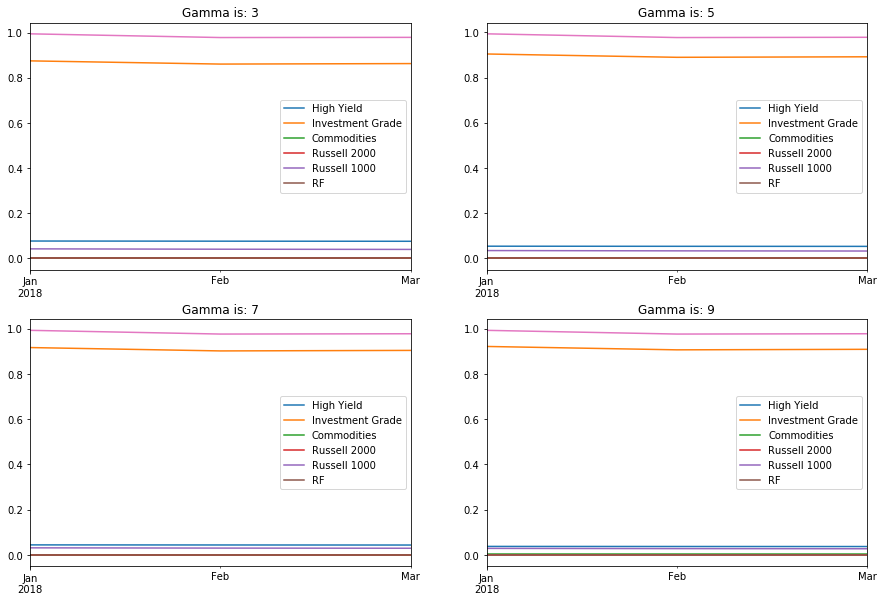

STARTING STATE IS 2


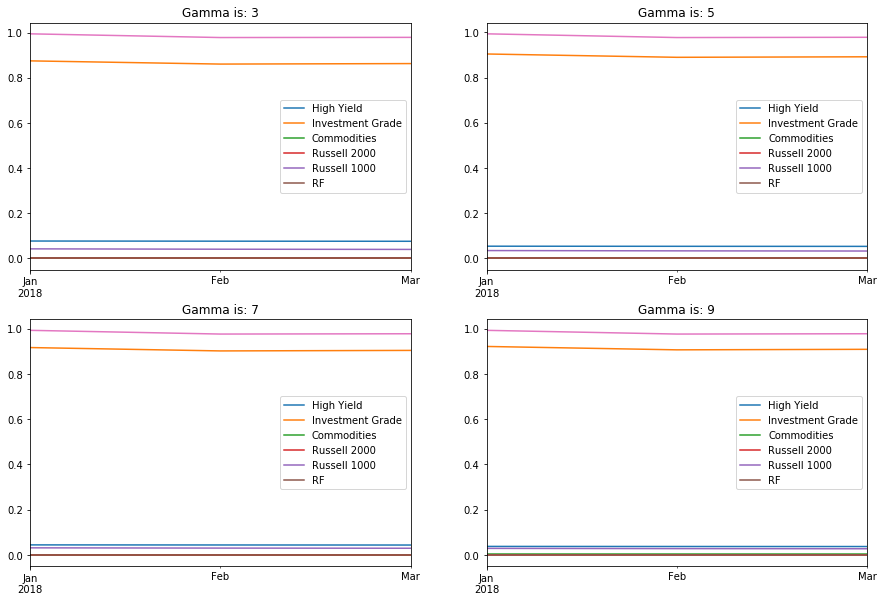

In [479]:
# [o]ut of sample [w]eights, gamma = 3 ==> [o][w]3
# Out of sample weights: start: 1, gamma: 3, maturity: 60 (index 8)
os1, os2 = 1, 2

oos_weights=[np.array(ws[os1][osg].iloc[8,:]) for osg in gamma]

# wealth at end of period
owealth1 = [oos_weights[i]*CR.iloc[:3,:] for i in range(len(gamma))]

print('STARTING STATE IS 1')
fig, axes = plt.subplots(2,2, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    owealth[i].plot(ax=ax)
    owealth[i].sum(axis=1).plot(ax=ax)
    ax.set_title('Gamma is: {}'.format(gamma[i]))
    ax.set_xlabel('')
plt.show()

oos_weights=[np.array(ws[os2][osg].iloc[8,:]) for osg in gamma]

# wealth at end of period
owealth2 = [oos_weights[i]*CR.iloc[:3,:] for i in range(len(gamma))]

print('STARTING STATE IS 2')
fig, axes = plt.subplots(2,2, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    owealth2[i].plot(ax=ax)
    owealth2[i].sum(axis=1).plot(ax=ax)
    ax.set_title('Gamma is: {}'.format(gamma[i]))
    ax.set_xlabel('')
plt.show()

In [108]:
epw_keys = [3,6,9,10,12,24,36,48,60]

epw = {}

for k in epw_keys:
    epw[k] = np.zeros((4,6))
    print('Maturity is: ', k)
    for i, g in enumerate([3,5,7,9]):
        args = returns_14.iloc[:k,:], g
        oos_result = boundedOptimiser(f, w, args, ApB, method='SLSQP')
        epw[k][i] = np.round(oos_result.x, 4)
        print('Optimal for gamma={}'.format(g), epw[k][i])

Maturity is:  3
Optimal for gamma=3 [0. 0. 1. 0. 0. 0.]
Optimal for gamma=5 [0. 0. 1. 0. 0. 0.]
Optimal for gamma=7 [0. 0. 1. 0. 0. 0.]
Optimal for gamma=9 [0. 0. 1. 0. 0. 0.]
Maturity is:  6
Optimal for gamma=3 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=5 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=7 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=9 [0. 0. 0. 0. 1. 0.]
Maturity is:  9
Optimal for gamma=3 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=5 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=7 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=9 [0. 0. 0. 0. 1. 0.]
Maturity is:  10
Optimal for gamma=3 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=5 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=7 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=9 [0. 0. 0. 0. 1. 0.]
Maturity is:  12
Optimal for gamma=3 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=5 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=7 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=9 [0. 0. 0. 0. 1. 0.]
Maturity is:  24
Optimal for gamma=3 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=5 [0. 0. 0. 0. 1. 0.]
Optimal for gamma=7 [

### Ex post optimal allocation is concentrated

From the above we see that ex post, one asset class performs better than a mix thereof. We can accept this finding intuitively, as, knowing what returns are, there is no danger in volatility.

### For all parameters

We now generalise the portfolio asset allocation problem to compare with several different parameters in (a) starting state, (b) investment horizon and (c) risk sensitivity.

Start state is:  1
Investment horizon:  3
Final return for g=3 is: 1.0297
Final return for g=5 is: 1.0311
Final return for g=7 is: 1.0353
Final return for g=9 is: 1.0378


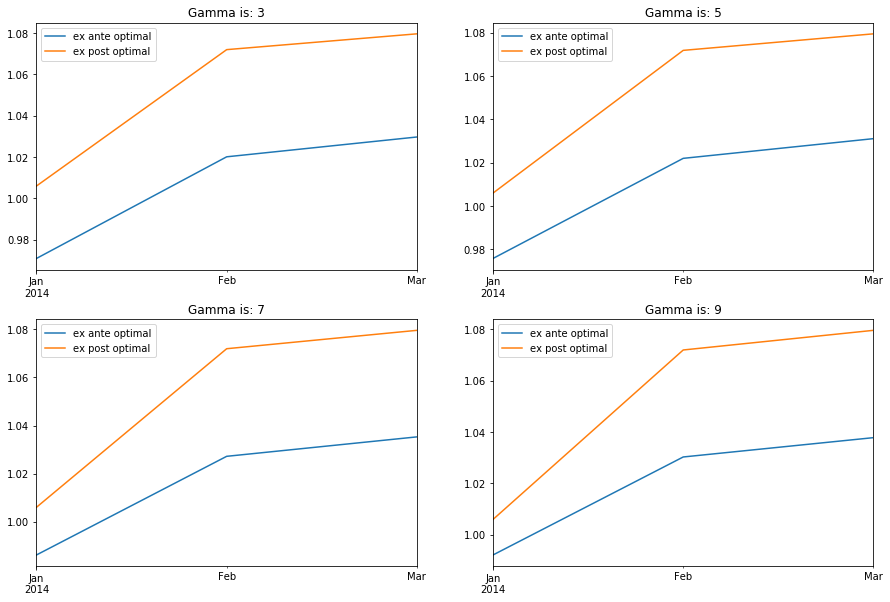

Investment horizon:  6
Final return for g=3 is: 1.0922
Final return for g=5 is: 1.0871
Final return for g=7 is: 1.0837
Final return for g=9 is: 1.0819


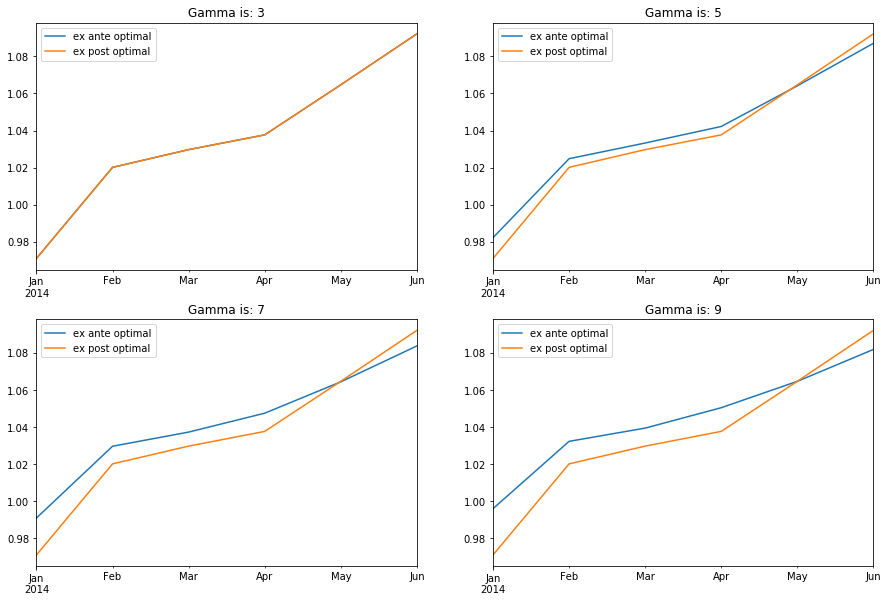

Investment horizon:  9
Final return for g=3 is: 1.1092
Final return for g=5 is: 1.0868
Final return for g=7 is: 1.0754
Final return for g=9 is: 1.0738


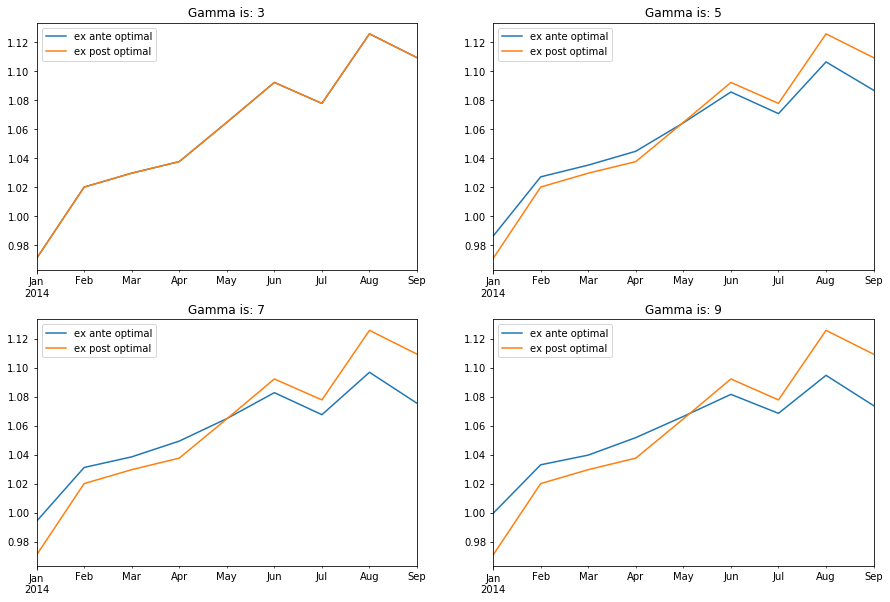

Investment horizon:  10
Final return for g=3 is: 1.1397
Final return for g=5 is: 1.1084
Final return for g=7 is: 1.0956
Final return for g=9 is: 1.0921


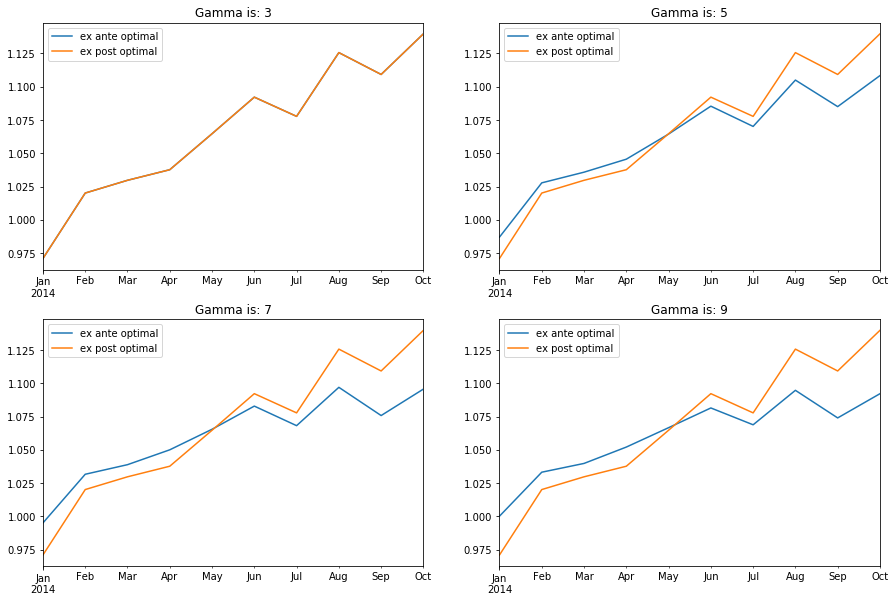

Investment horizon:  12
Final return for g=3 is: 1.1691
Final return for g=5 is: 1.1095
Final return for g=7 is: 1.0952
Final return for g=9 is: 1.0911


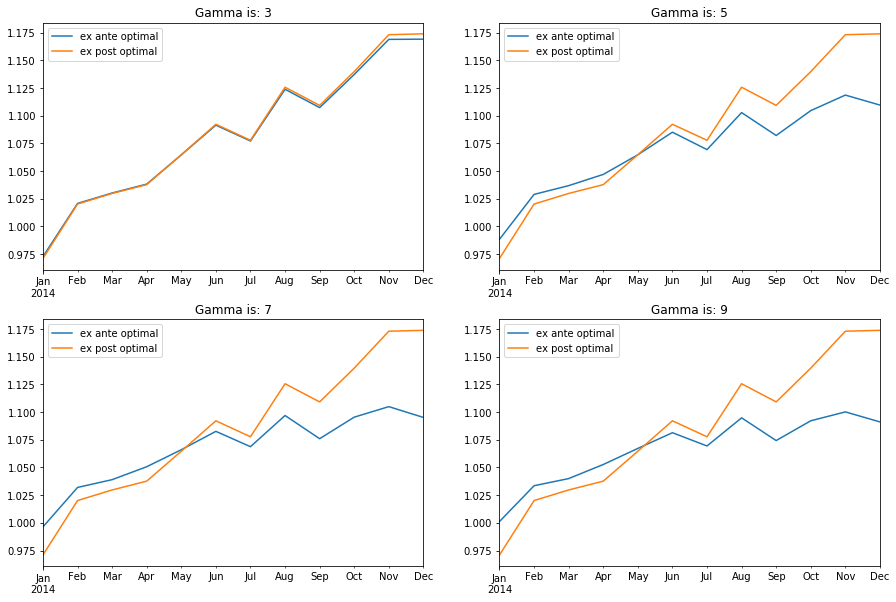

Investment horizon:  24
Final return for g=3 is: 1.1752
Final return for g=5 is: 1.1128
Final return for g=7 is: 1.1048
Final return for g=9 is: 1.1006


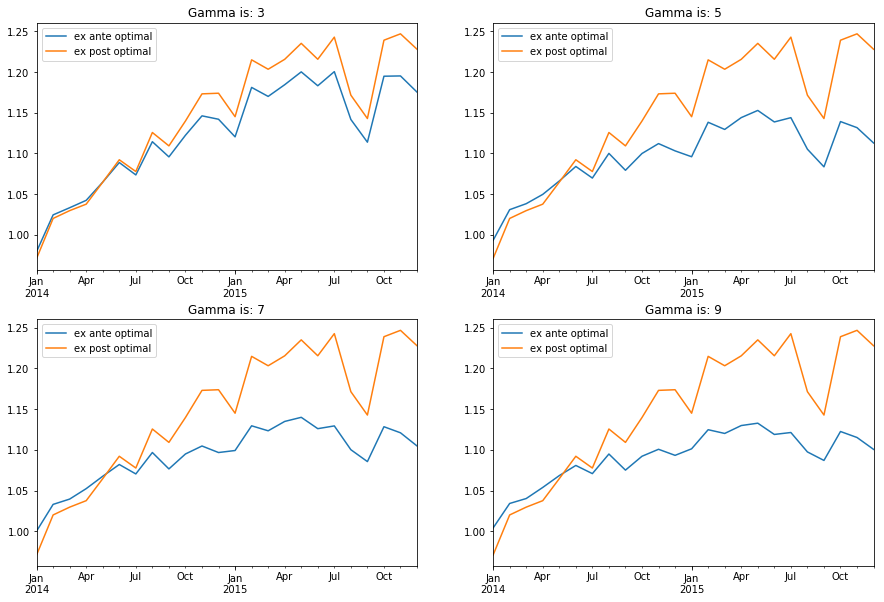

Investment horizon:  36
Final return for g=3 is: 1.3611
Final return for g=5 is: 1.296
Final return for g=7 is: 1.2725
Final return for g=9 is: 1.2596


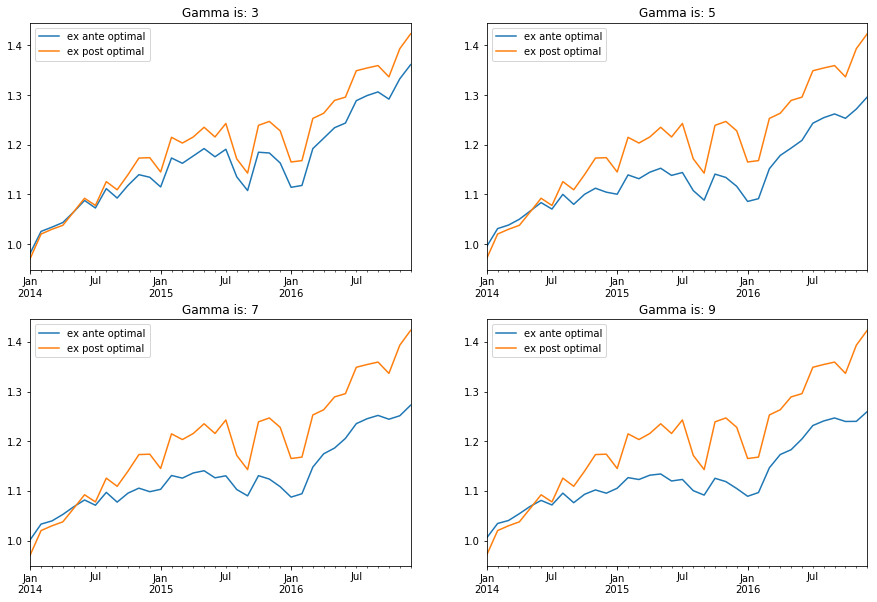

Investment horizon:  48
Final return for g=3 is: 1.642
Final return for g=5 is: 1.512
Final return for g=7 is: 1.4595
Final return for g=9 is: 1.4301


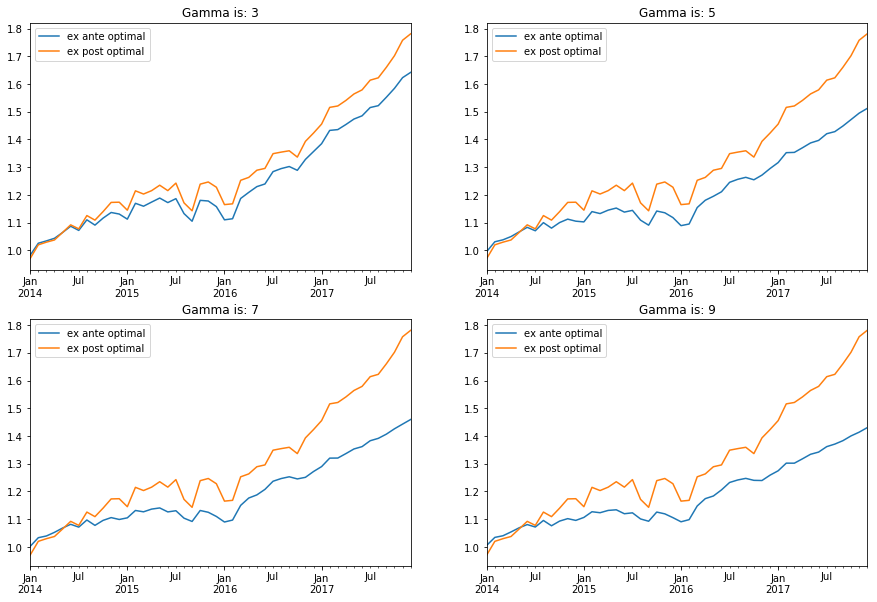

Investment horizon:  60
Final return for g=3 is: 1.5974
Final return for g=5 is: 1.4801
Final return for g=7 is: 1.4316
Final return for g=9 is: 1.4044


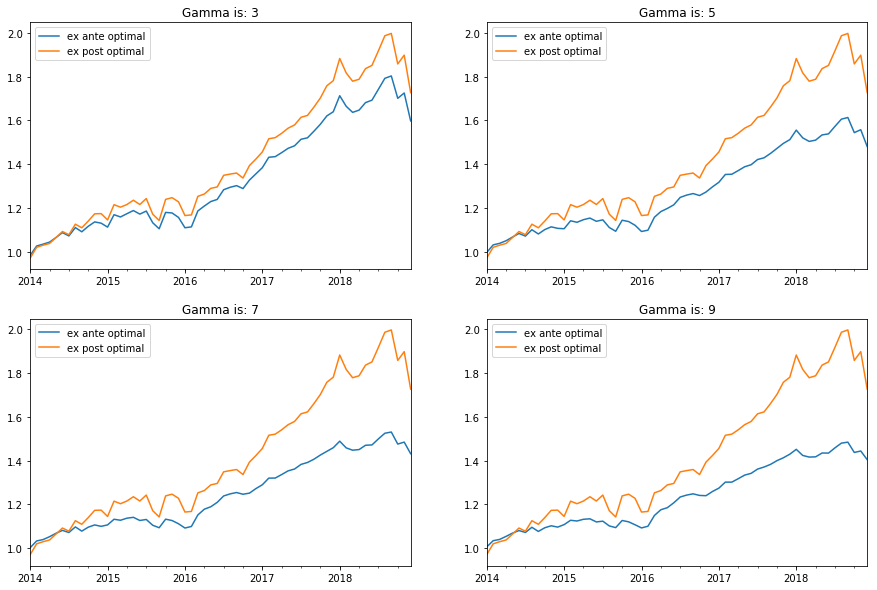

Start state is:  2
Investment horizon:  3
Final return for g=3 is: 1.0384
Final return for g=5 is: 1.0392
Final return for g=7 is: 1.0397
Final return for g=9 is: 1.04


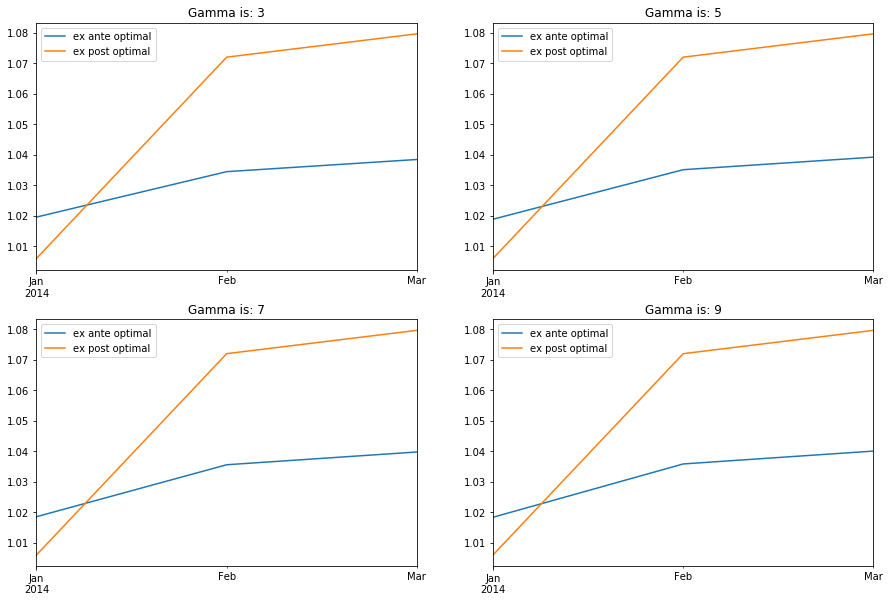

Investment horizon:  6
Final return for g=3 is: 1.0779
Final return for g=5 is: 1.078
Final return for g=7 is: 1.078
Final return for g=9 is: 1.0778


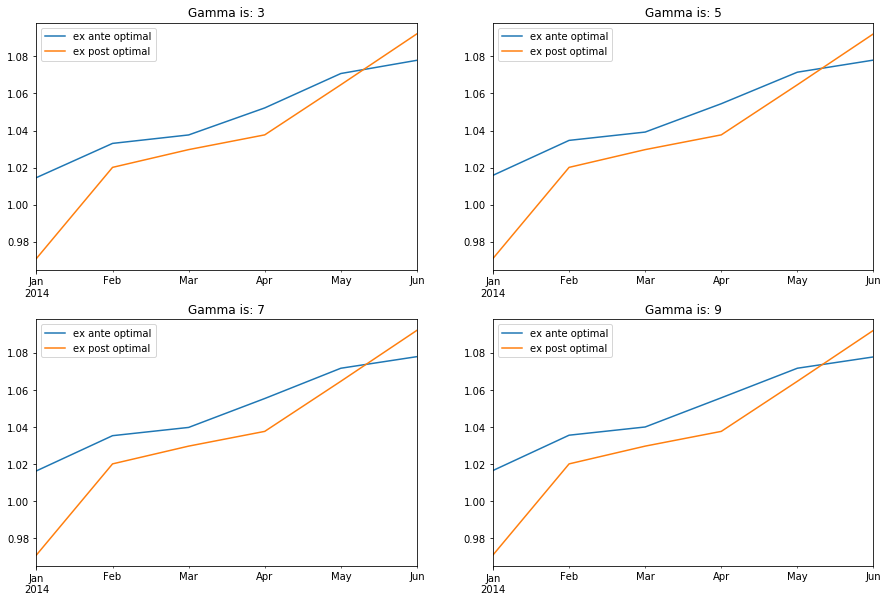

Investment horizon:  9
Final return for g=3 is: 1.0876
Final return for g=5 is: 1.0836
Final return for g=7 is: 1.0818
Final return for g=9 is: 1.0807


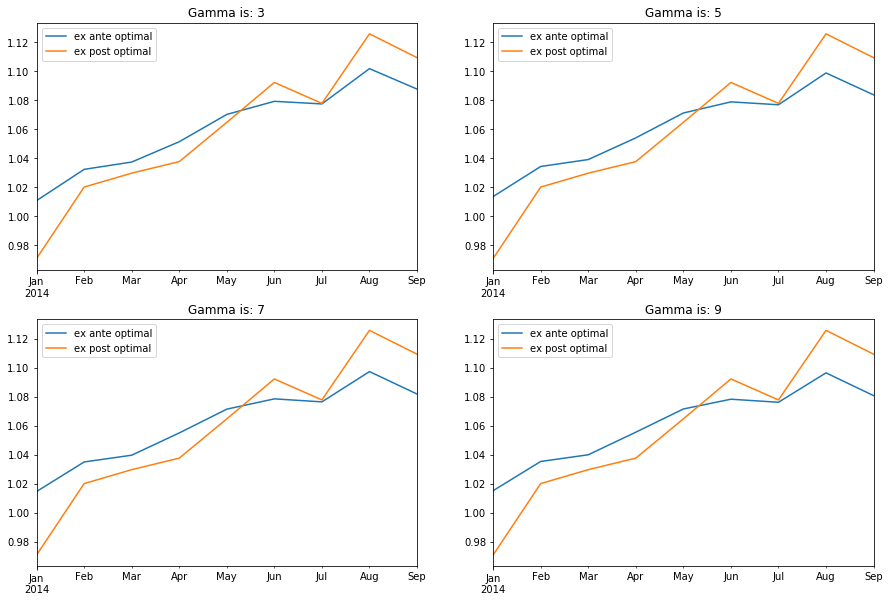

Investment horizon:  10
Final return for g=3 is: 1.1052
Final return for g=5 is: 1.0994
Final return for g=7 is: 1.0969
Final return for g=9 is: 1.0955


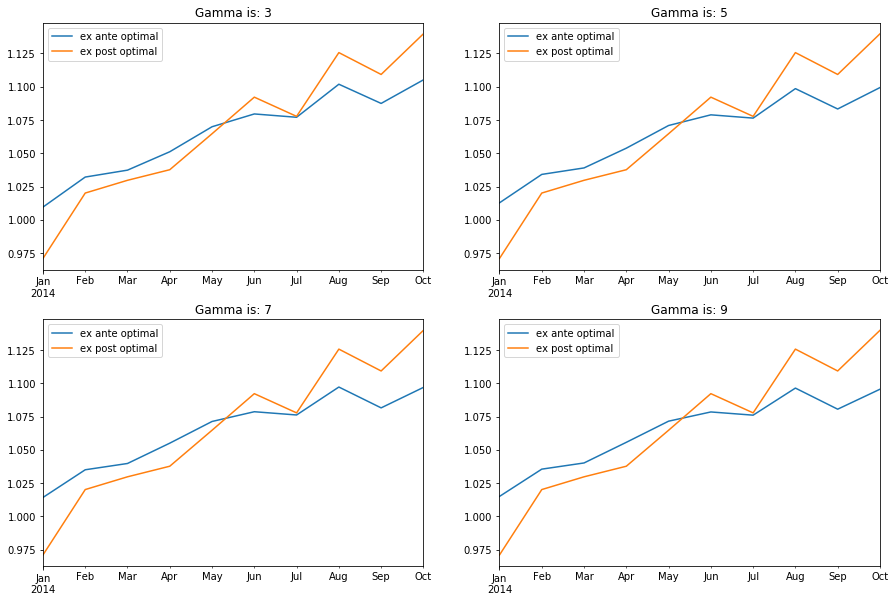

Investment horizon:  12
Final return for g=3 is: 1.1193
Final return for g=5 is: 1.1098
Final return for g=7 is: 1.1058
Final return for g=9 is: 1.1035


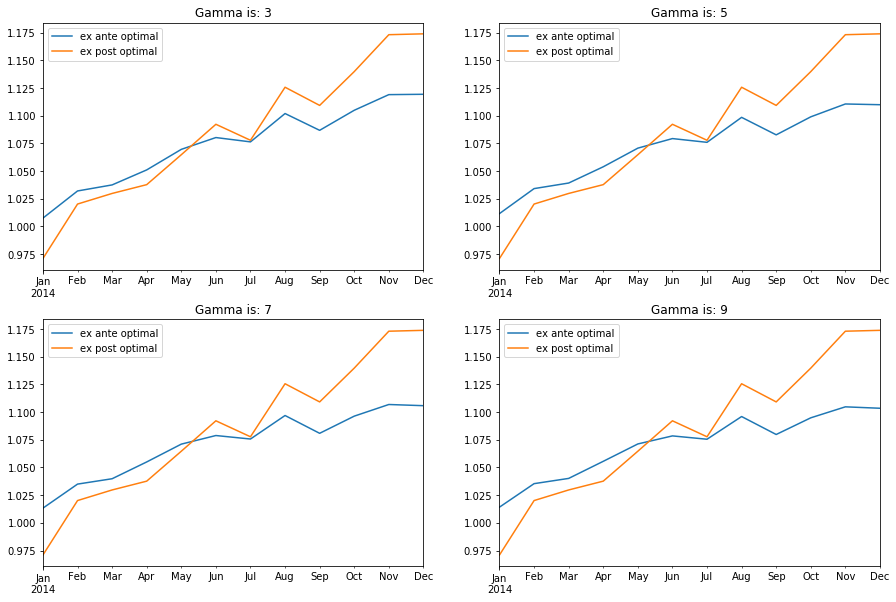

Investment horizon:  24
Final return for g=3 is: 1.1418
Final return for g=5 is: 1.1266
Final return for g=7 is: 1.1201
Final return for g=9 is: 1.1168


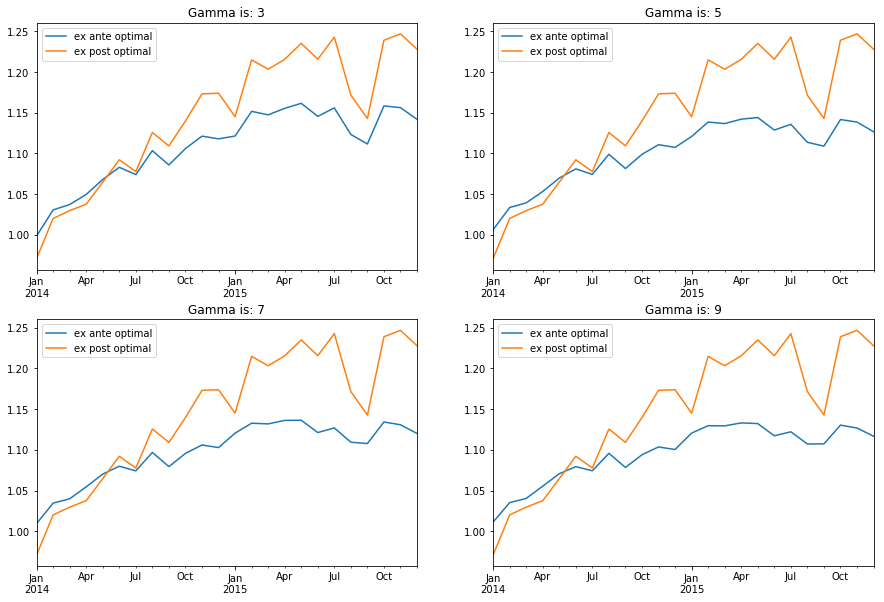

Investment horizon:  36
Final return for g=3 is: 1.313
Final return for g=5 is: 1.276
Final return for g=7 is: 1.2602
Final return for g=9 is: 1.2513


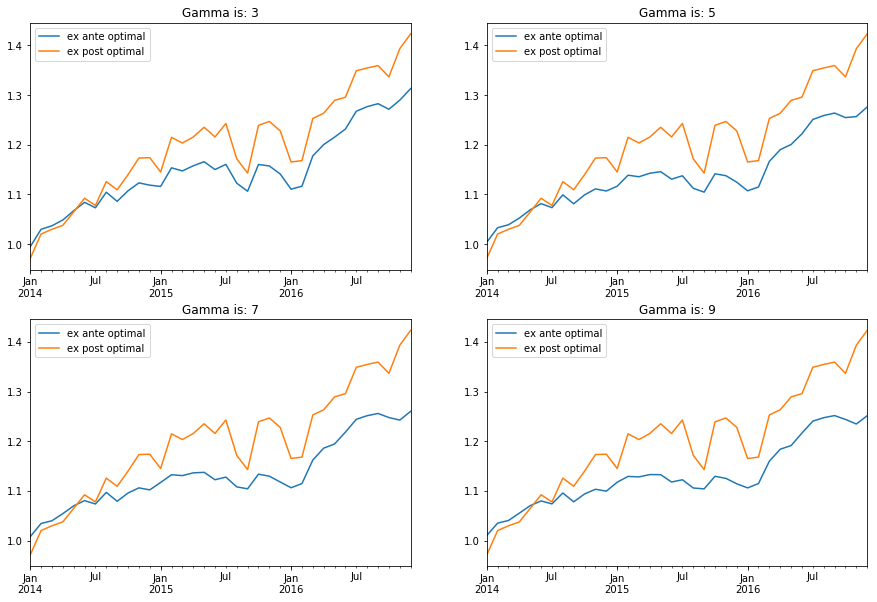

Investment horizon:  48
Final return for g=3 is: 1.5584
Final return for g=5 is: 1.47
Final return for g=7 is: 1.4317
Final return for g=9 is: 1.4104


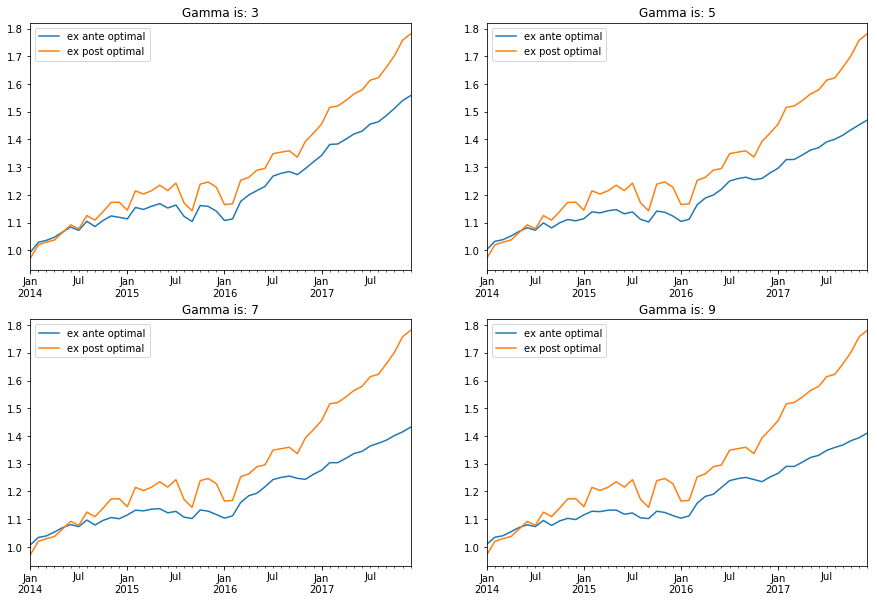

Investment horizon:  60
Final return for g=3 is: 1.5347
Final return for g=5 is: 1.4483
Final return for g=7 is: 1.4109
Final return for g=9 is: 1.3901


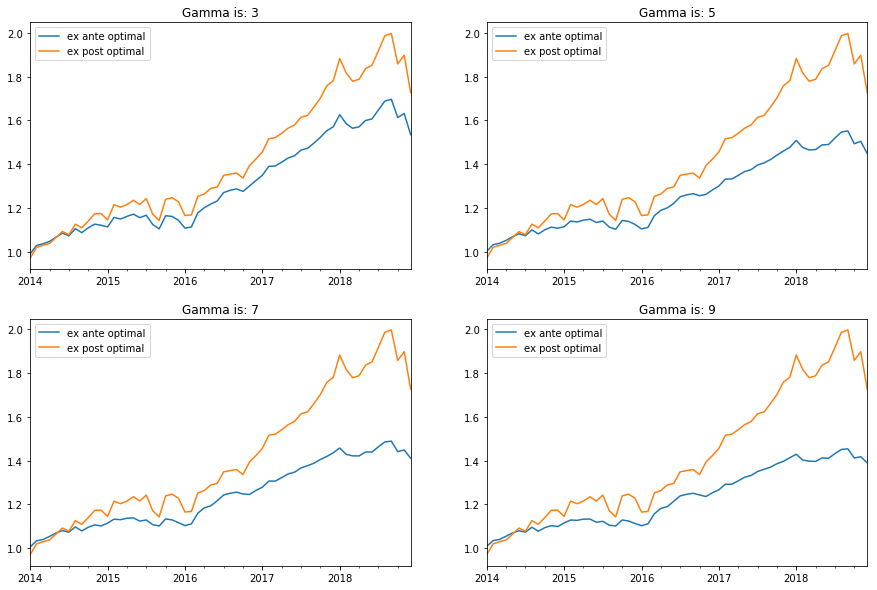

In [109]:
for s in start_states:
    print('Start state is: ', s)
    for j, k in enumerate(epw_keys):
        print('Investment horizon: ', k)
        
        # .iloc[j,:] has j be the maturity by index -> [3,6,9,10,12]
        ows = [np.array(ws[s][g].iloc[j,:]) for g in gamma]
        
        fig, axes = plt.subplots(2,2, figsize=(15,10))        
        for i, ax in enumerate(axes.flat):
            
            # i is the gamma [3,5,7,9]
            owealth = ows[i]*CR.iloc[:k,:]
            opt_wealth = epw[k][i]*CR.iloc[:k,:]
            
            # Actual plotting
            owealth.sum(axis=1).plot(ax=ax, label='ex ante optimal')
            opt_wealth.sum(axis=1).plot(ax=ax, label='ex post optimal')
            
            # Tidying up
            ax.set_title('Gamma is: {}'.format(gamma[i]))
            ax.set_xlabel('')
            ax.legend()
            
            print('Final return for g={} is: {}'.format(
                gamma[i], np.round(owealth.iloc[k-1].sum(), 4))
            )
            
        plt.show()

## Conclusion

We have now compared the optimal portfolio allocation for a 2 state Hidden Markov Switching model across parameters:

* States: 1, 2
* Maturities: 3, 6, 9, 10, 12
* Risk sensitivity: 3, 5, 7, 9

In addition, we find the following conclusions:
1. We find that we can never outperform the ex post optimal allocation as expected.

2. For an investment horizon of `10 months` and starting in `state 1` we almost perform as good as the ex post allocation.

3. Starting in the wrong state (state 2) is a bad idea. Our allocation is not in alignment with market conditions. We never get near the ex post allocation.

4. Starting in the right state (state 1) allows us to outperform the ex post allocation at some point in the investment period always.

5. We are never prepared for the crashes of October and December in the scenario of starting in state 1.

6. The crash in December is handled well for the allocations starting in state 2. The September crash is not handled well.

7. Only time we make positive profits is when the investment horizon is either 6, 9, or 10 months, conditional on starting the allocation from state 1.

8. If we believe we start in state 1, then a high risk tolerance (large $\gamma$) leads to the highest profits over the period we have considered.

9. If we believe we start in state 2, then a high risk aversion (low $\gamma$) leads to the highest profits for short maturities (9 months or less). This difference is not pronounced.